## Offline Reinforcement Learning Algorithms for CartPole

This notebook implements and compares three offline RL algorithms:
1. Behavior Cloning (BC)
2. Offline Deep Q-Network (DQN)
3. Conservative Q-Learning (CQL)

We evaluate each algorithm on three datasets:
- Expert data: High-quality demonstrations
- Random data: Random policy interactions
- Mixed data: Combination of expert and random data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from tabulate import tabulate
import random
import copy
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 18,
    'figure.figsize': (10, 6),
})


### Behavior Cloning 

In [3]:
# Define the Behavior Cloning Policy Network
class BCPolicyNet(nn.Module):
    def __init__(self, input_dim=4, hidden_dims=[128, 128], output_dim=2):
        super(BCPolicyNet, self).__init__()
        
        # Create the first hidden layer
        layers = [nn.Linear(input_dim, hidden_dims[0]), nn.ReLU()]
        
        # Add remaining hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        
        # Add output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        # Combine all layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [4]:
# Function to load and preprocess dataset
def load_dataset(dataset_path, test_size=0.2):
    # Load data
    data = np.load(dataset_path)
    
    # Extract observations and actions
    observations = data['observations']
    actions = data['actions']
    
    print(f"Loaded dataset with {len(observations)} transitions")
    print(f"Action distribution: {np.bincount(actions, minlength=2)}")
    
    # Split into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        observations, actions, test_size=test_size, random_state=42)
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    X_val = torch.FloatTensor(X_val)
    y_val = torch.LongTensor(y_val)
    
    # Create datasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    print(f"Training set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    
    return train_dataset, val_dataset

In [29]:
# Training function with learning curve tracking
def train_bc_model(train_dataset, val_dataset, model, epochs=20, batch_size=64, lr=1e-3):
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Track metrics
    train_losses = []
    val_accuracies = []
    epochs_list = []
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss = 0
        
        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
        
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)
        epochs_list.append(epoch + 1)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    
    # Return metrics including learning curve
    return train_losses, val_accuracies, val_accuracy, epochs_list

# Function to evaluate model with reduced verbosity
def evaluate_policy(model, env_name="CartPole-v1", num_episodes=20):
    env = gym.make(env_name)
    episode_rewards = []
    
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # Convert observation to tensor
            obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
            
            # Get action from the model
            with torch.no_grad():
                logits = model(obs_tensor)
                action = torch.argmax(logits, dim=1).item()
            
            # Take action in the environment
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        
        episode_rewards.append(total_reward)
        # Only print individual episode rewards for final evaluation (20 episodes)
        if num_episodes <= 10 or i % 5 == 0:
            print(f"Episode {i+1}: Reward = {total_reward}")
    
    avg_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"Average Reward: {avg_reward:.2f} ± {std_reward:.2f}")
    
    env.close()
    return avg_reward, std_reward, episode_rewards


In [6]:
# Function to plot BC learning curves 
def plot_bc_learning_curve(eval_steps, eval_accuracies, title_prefix=""):
    plt.figure(figsize=(10, 5))
    plt.plot(eval_steps, eval_accuracies)
    plt.title(f'BC Learning Curve - {title_prefix} Dataset')
    plt.xlabel('Training Epochs')
    plt.ylabel('Validation Accuracy')  
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [30]:

# Function to run full experiment for a dataset
def run_bc_experiment(dataset_path, model_save_path, dataset_name):
    print(f"\n{'='*20} BC Model on {dataset_name} Dataset {'='*20}")
    
    # Load dataset
    train_dataset, val_dataset = load_dataset(dataset_path)
    
    # Create model
    model = BCPolicyNet(input_dim=4, hidden_dims=[128, 128], output_dim=2)
    
    # Train model
    start_time = time.time()
    train_losses, val_accuracies, final_val_accuracy, epochs_list = train_bc_model(
        train_dataset, val_dataset, model, epochs=20, batch_size=64, lr=1e-3)
    training_time = time.time() - start_time
    
    # Save model
    torch.save(model.state_dict(), model_save_path)
    
    # Plot learning curve
    plot_bc_learning_curve(epochs_list, val_accuracies, title_prefix=dataset_name)
    
    # Evaluate model
    avg_reward, std_reward, _ = evaluate_policy(model)
    
    return {
        "dataset": dataset_name,
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "val_accuracy": final_val_accuracy * 100,  # Convert to percentage
        "training_time": training_time,
        "learning_curve": (epochs_list, val_accuracies)
    }

# Function to run behavior cloning experiments
def run_bc_experiments():
    # Define dataset configurations
    datasets = [
        {"path": "expert_data.npz", "save_path": "bc_expert_model.pt", "name": "Expert"},
        {"path": "mixed_data.npz", "save_path": "bc_mixed_model.pt", "name": "Mixed"},
        {"path": "random_data.npz", "save_path": "bc_random_model.pt", "name": "Random"}
    ]
    
    # Run experiments and collect results
    results = []
    learning_curves = {}
    
    for dataset_config in datasets:
        result = run_bc_experiment(
            dataset_config["path"], 
            dataset_config["save_path"], 
            dataset_config["name"]
        )
        results.append(result)
        learning_curves[result["dataset"]] = result["learning_curve"]
    
    # Display results in a table
    print("\n" + "="*50)
    print("BEHAVIOR CLONING RESULTS SUMMARY")
    print("="*50)
    
    # Format the table
    table_data = []
    for result in results:
        table_data.append([
            result["dataset"],
            f"{result['avg_reward']:.2f} ± {result['std_reward']:.2f}",
            f"{result['val_accuracy']:.2f}%", 
            f"{result['training_time']:.2f}s"
        ])
    
    headers = ["Dataset", "Avg Reward ± Std", "Val Accuracy", "Training Time"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    # Create comparison bar chart
    plt.figure(figsize=(10, 6))
    
    # Dataset names and rewards
    datasets = [r["dataset"] for r in results]
    rewards = [r["avg_reward"] for r in results]
    errors = [r["std_reward"] for r in results]
    
    # Create bar chart with error bars
    plt.bar(datasets, rewards, yerr=errors, capsize=10, alpha=0.7)
    plt.ylabel('Average Reward')
    plt.title('BC Performance Comparison Across Datasets')
    plt.ylim(0, 500)  # CartPole max is 500
    
    # Add value labels on the bars
    for i, v in enumerate(rewards):
        plt.text(i, v + 10, f"{v:.1f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Plot combined learning curves
    plt.figure(figsize=(10, 5))
    for dataset, (epochs, accuracies) in learning_curves.items():
        plt.plot(epochs, accuracies, label=dataset)
    
    plt.xlabel('Training Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title('BC Learning Curves')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results



## Offline Deep Q-Network (DQN)

In [8]:
# DQN Network architecture (same as BC but with double output for Q-values)
class DQNNetwork(nn.Module):
    def __init__(self, input_dim=4, hidden_dims=[128, 128], output_dim=2):
        super(DQNNetwork, self).__init__()
        
        # Create the first hidden layer
        layers = [nn.Linear(input_dim, hidden_dims[0]), nn.ReLU()]
        
        # Add remaining hidden layers
        for i in range(len(hidden_dims) - 1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        
        # Add output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        # Combine all layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Replay Buffer for Offline DQN (loads data from dataset)
class OfflineReplayBuffer:
    def __init__(self, dataset_path, batch_size=64):
        # Load dataset
        data = np.load(dataset_path)
        
        # Extract data
        self.observations = data['observations']
        self.actions = data['actions']
        self.rewards = data['rewards']
        self.next_observations = data['next_observations']
        self.dones = data['dones']
        
        self.batch_size = batch_size
        self.size = len(self.observations)
        
        print(f"Loaded dataset with {self.size} transitions")
        print(f"Action distribution: {np.bincount(self.actions, minlength=2)}")
        
    def sample(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
            
        # Random sampling from the dataset
        indices = np.random.randint(0, self.size, size=batch_size)
        
        # Get batch data
        states = torch.FloatTensor(self.observations[indices])
        actions = torch.LongTensor(self.actions[indices])
        rewards = torch.FloatTensor(self.rewards[indices])
        next_states = torch.FloatTensor(self.next_observations[indices])
        dones = torch.FloatTensor(self.dones[indices])
        
        return states, actions, rewards, next_states, dones

# Offline DQN Agent
class OfflineDQNAgent:
    def __init__(
        self,
        state_dim=4,
        action_dim=2,
        hidden_dims=[128, 128],
        lr=1e-3,
        gamma=0.99,
        target_update_freq=10,
        batch_size=64
    ):
        # Initialize networks
        self.q_network = DQNNetwork(state_dim, hidden_dims, action_dim)
        self.target_network = copy.deepcopy(self.q_network)
        
        # Freeze target network parameters
        for param in self.target_network.parameters():
            param.requires_grad = False
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Set hyperparameters
        self.gamma = gamma
        self.target_update_freq = target_update_freq
        self.batch_size = batch_size
        self.update_counter = 0
        
        # Track losses for visualization
        self.losses = []
        self.avg_q_values = []
    
    def update(self, states, actions, rewards, next_states, dones):
        # Get current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values
        with torch.no_grad():
            # Double DQN: Use online network to select actions, target network to evaluate
            next_actions = self.q_network(next_states).argmax(1)
            next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + self.gamma * next_q_values * (1 - dones)
        
        # Compute loss (MSE)
        loss = nn.MSELoss()(current_q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Log metrics
        self.losses.append(loss.item())
        self.avg_q_values.append(current_q_values.mean().item())
        
        # Update target network if needed
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        return loss.item()
    
    def select_action(self, state, epsilon=0.0):
        # Convert state to tensor
        if not isinstance(state, torch.Tensor):
            state = torch.FloatTensor(state).unsqueeze(0)
        
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            return random.randint(0, 1)
        else:
            with torch.no_grad():
                q_values = self.q_network(state)
                return q_values.argmax().item()
    
    def save(self, path):
        torch.save(self.q_network.state_dict(), path)
    
    def load(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.q_network.state_dict())


In [10]:
# Function to train Offline DQN
def train_offline_dqn(agent, replay_buffer, num_updates=10000, eval_freq=500, eval_episodes=5):
    print("Starting Offline DQN training...")
    
    # Metrics to track
    eval_rewards = []
    timesteps = []
    
    # Training loop
    for update in tqdm(range(num_updates)):
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = replay_buffer.sample()
        
        # Update the agent
        loss = agent.update(states, actions, rewards, next_states, dones)
        
        # Evaluate periodically
        if (update + 1) % eval_freq == 0:
            avg_reward = evaluate_agent(agent, eval_episodes)
            eval_rewards.append(avg_reward)
            timesteps.append(update + 1)
            print(f"Update {update+1}/{num_updates}, Avg. Reward: {avg_reward:.2f}")
    
    return {
        'eval_rewards': eval_rewards,
        'timesteps': timesteps,
        'losses': agent.losses,
        'q_values': agent.avg_q_values
    }

# Function to evaluate agent
def evaluate_agent(agent, num_episodes=20):
    env = gym.make("CartPole-v1")
    episode_rewards = []
    
    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # Select action
            action = agent.select_action(obs)
            
            # Take action in the environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Update total reward
            total_reward += reward
            
            # Update observation
            obs = next_obs
        
        episode_rewards.append(total_reward)
    
    env.close()
    avg_reward = sum(episode_rewards) / num_episodes
    return avg_reward

# Function for final evaluation with mean and std
def final_evaluate(agent, num_episodes=20):
    env = gym.make("CartPole-v1")
    episode_rewards = []
    
    for i in range(num_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        
        while not done:
            # Select action
            action = agent.select_action(obs)
            
            # Take action in the environment
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Update total reward
            total_reward += reward
            
            # Update observation
            obs = next_obs
        
        episode_rewards.append(total_reward)
        print(f"Episode {i+1}: Reward = {total_reward}")
    
    env.close()
    avg_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    print(f"\nAverage Reward over {num_episodes} episodes: {avg_reward:.2f} ± {std_reward:.2f}")
    
    return avg_reward, std_reward


In [11]:
# Function to plot DQN learning curve
def plot_dqn_learning_curve(metrics, title_prefix):
    plt.figure(figsize=(10, 5))
    # Plot evaluation rewards
    plt.plot(metrics['timesteps'], metrics['eval_rewards'])
    plt.xlabel('Training Updates')
    plt.ylabel('Average Reward')
    plt.title(f'Offline DQN Learning Curve - {title_prefix} Dataset')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [12]:
# Function to run experiment for a dataset
def run_offline_dqn_experiment(dataset_path, model_save_path, dataset_name):
    print(f"\n{'='*20} Offline DQN on {dataset_name} Dataset {'='*20}")
    
    # Initialize replay buffer with the dataset
    replay_buffer = OfflineReplayBuffer(dataset_path, batch_size=64)
    
    # Initialize agent
    agent = OfflineDQNAgent(
        state_dim=4,
        action_dim=2,
        hidden_dims=[128, 128],
        lr=1e-3,
        gamma=0.99,
        target_update_freq=10,
        batch_size=64
    )
    
    # Train agent
    start_time = time.time()
    training_metrics = train_offline_dqn(
        agent, 
        replay_buffer, 
        num_updates=10000,
        eval_freq=500,
        eval_episodes=5
    )
    training_time = time.time() - start_time
    
    # Save trained model
    agent.save(model_save_path)
    
    # Plot learning curve
    plot_dqn_learning_curve(training_metrics, dataset_name)
    
    # Evaluate final model
    print(f"Evaluating final {dataset_name} policy...")
    avg_reward, std_reward = final_evaluate(agent)
    
    return {
        "dataset": dataset_name,
        "avg_reward": avg_reward,
        "std_reward": std_reward,
        "final_loss": agent.losses[-1],
        "training_time": training_time,
        "learning_curve": (training_metrics['timesteps'], training_metrics['eval_rewards'])
    }

# Function to run offline DQN experiments
def run_offline_dqn_experiments():
    # Define dataset configurations
    datasets = [
        {"path": "expert_data.npz", "save_path": "offline_dqn_expert.pt", "name": "Expert"},
        {"path": "mixed_data.npz", "save_path": "offline_dqn_mixed.pt", "name": "Mixed"},
        {"path": "random_data.npz", "save_path": "offline_dqn_random.pt", "name": "Random"}
    ]
    
    # Run experiments and collect results
    results = []
    learning_curves = {}
    
    for dataset_config in datasets:
        result = run_offline_dqn_experiment(
            dataset_config["path"], 
            dataset_config["save_path"], 
            dataset_config["name"]
        )
        results.append(result)
        learning_curves[result["dataset"]] = result["learning_curve"]
    
    # Display results in a table
    print("\n" + "="*50)
    print("OFFLINE DQN RESULTS SUMMARY")
    print("="*50)
    
    # Format the table
    table_data = []
    for result in results:
        table_data.append([
            result["dataset"],
            f"{result['avg_reward']:.2f} ± {result['std_reward']:.2f}",
            f"{result['training_time']:.2f}s"
        ])
    
    headers = ["Dataset", "Avg Reward ± Std", "Training Time"]
    print(tabulate(table_data, headers=headers, tablefmt="grid"))
    
    # Create comparison bar chart
    plt.figure(figsize=(10, 6))
    
    # Dataset names and rewards
    datasets = [r["dataset"] for r in results]
    rewards = [r["avg_reward"] for r in results]
    errors = [r["std_reward"] for r in results]
    
    # Create bar chart with error bars
    plt.bar(datasets, rewards, yerr=errors, capsize=10, alpha=0.7)
    plt.ylabel('Average Reward')
    plt.title('Offline DQN Performance Comparison Across Datasets')
    plt.ylim(0, 500)  # CartPole max is 500
    
    # Add value labels on the bars
    for i, v in enumerate(rewards):
        plt.text(i, v + 10, f"{v:.1f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Plot combined learning curves
    plt.figure(figsize=(10, 5))
    for dataset, (steps, rewards) in learning_curves.items():
        plt.plot(steps, rewards, label=dataset)
    
    plt.xlabel('Training Updates')
    plt.ylabel('Average Reward')
    plt.title('Offline DQN Learning Curves')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results


## Conservative Q-Learning (CQL)

In [13]:
try:
    from d3rlpy.dataset import MDPDataset
    from d3rlpy.algos.qlearning import DiscreteCQLConfig
except ImportError:
    print("d3rlpy not found. Installing...")
    import pip
    pip.main(['install', 'd3rlpy'])
    from d3rlpy.dataset import MDPDataset
    from d3rlpy.algos.qlearning import DiscreteCQLConfig

# Function to create a CQL algorithm with proper config
def build_cql(batch_size=256, conservative_weight=1.0):
    cfg = DiscreteCQLConfig()
    cfg.batch_size = batch_size
    cfg.conservative_weight = conservative_weight  # ≈ alpha
    return cfg.create(device="cpu")  # CPU for compatibility

In [14]:
# Function to load an offline dataset into MDPDataset format
def load_cql_dataset(path):
    print(f"Loading dataset from {path}")
    data = np.load(path)
    
    dataset = MDPDataset(
        observations=data["observations"].astype(np.float32),
        actions=data["actions"].astype(np.int32),
        rewards=data["rewards"].astype(np.float32),
        terminals=data["dones"].astype(bool),
    )
    
    # For diagnostic info
    n_transitions = len(data["observations"])
    action_dist = np.bincount(data["actions"], minlength=2)
    print(f"Dataset contains {n_transitions} transitions")
    print(f"Action distribution: {action_dist}")
    
    return dataset

In [15]:
# Custom evaluation function
def eval_cql_policy(model, n_episodes=20):
    env = gym.make("CartPole-v1")
    returns = []
    for i in range(n_episodes):
        obs, _ = env.reset()
        done, total = False, 0
        while not done:
            act = model.predict(obs[None, :])[0]
            obs, r, term, trunc, _ = env.step(int(act))
            done, total = term or trunc, total + r
        returns.append(total)
        print(f"Episode {i+1}: Reward = {total}")
    env.close()
    avg, std = np.mean(returns), np.std(returns)
    print(f"Average return: {avg:.2f} ± {std:.2f}")
    return returns, avg, std

In [16]:
# Function to train and evaluate CQL on a dataset
def train_and_evaluate_cql(dataset_path, model_save_path, dataset_name):
    print(f"\n{'='*20} Training CQL on {dataset_name} Dataset {'='*20}")
    
    # 1. load dataset
    dataset = load_cql_dataset(dataset_path)

    # 2. build model
    cql = build_cql()

    # 3. train
    n_steps = 20_000    
    eval_episodes = 5
    eval_period = 1000 
    
    # Initialize tracking metrics
    rewards_history = []
    step_history = []
    
    print(f"Training CQL on {dataset_name} dataset...")
    start = time.time()
    
    # Custom training loop with periodic evaluation
    for step in range(0, n_steps, eval_period):
        cql.fit(dataset, n_steps=eval_period, n_steps_per_epoch=eval_period)
        
        # Evaluate current policy
        _, avg_r, _ = eval_cql_policy(cql, n_episodes=eval_episodes)
        
        # Record metrics
        rewards_history.append(avg_r)
        step_history.append(step + eval_period)
        
        print(f"Step {step + eval_period}/{n_steps}, Avg Reward: {avg_r:.2f}")
    
    train_time = time.time() - start

    # 4. save
    cql.save_model(model_save_path)

    # 5. evaluate 20 episodes
    _, avg_r, std_r = eval_cql_policy(cql, n_episodes=20)
    print(f"Final: {avg_r:.2f} ± {std_r:.2f}, Training time: {train_time:.2f}s")

    # Plot learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(step_history, rewards_history)
    plt.xlabel('Training Steps')
    plt.ylabel('Average Reward')
    plt.title(f'CQL Learning Curve - {dataset_name} Dataset')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return {
        "dataset": dataset_name,
        "avg_reward": avg_r,
        "std_reward": std_r,
        "training_time": train_time,
        "rewards_history": rewards_history,
        "step_history": step_history
    }

# Function to run CQL experiments
def run_cql_experiments():
    datasets = [
        {"path": "expert_data.npz", "save_path": "cql_expert.d3", "name": "Expert"},
        {"path": "mixed_data.npz", "save_path": "cql_mixed.d3", "name": "Mixed"},
        {"path": "random_data.npz", "save_path": "cql_random.d3", "name": "Random"}
    ]
    
    results = []
    learning_curves = {}
    
    for dataset_config in datasets:
        result = train_and_evaluate_cql(
            dataset_config["path"],
            dataset_config["save_path"],
            dataset_config["name"]
        )
        
        results.append(result)
        
        if result["rewards_history"]:
            learning_curves[result["dataset"]] = {
                "steps": result["step_history"],
                "rewards": result["rewards_history"]
            }
    
    # Print summary table
    print("\n" + "="*50)
    print("CONSERVATIVE Q-LEARNING RESULTS SUMMARY")
    print("="*50)
    
    table_data = []
    for result in results:
        table_data.append([
            result["dataset"],
            f"{result['avg_reward']:.2f} ± {result['std_reward']:.2f}",
            f"{result['training_time']:.2f}s"
        ])
    
    print(tabulate(
        table_data,
        headers=["Dataset", "Avg Reward ± Std", "Training Time"],
        tablefmt="grid"
    ))
    
    # Create comparison bar chart
    plt.figure(figsize=(10, 6))
    
    # Extract data
    datasets = [r["dataset"] for r in results]
    avgs = [r["avg_reward"] for r in results]
    stds = [r["std_reward"] for r in results]
    
    # Create bar chart
    plt.bar(datasets, avgs, yerr=stds, capsize=10, alpha=0.7)
    plt.ylabel("Average Reward")
    plt.title("CQL Performance Comparison Across Datasets")
    plt.ylim(0, 500)  # CartPole max is 500
    
    # Add value labels on the bars
    for i, v in enumerate(avgs):
        plt.text(i, v + 10, f"{v:.1f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Plot combined learning curves
    plt.figure(figsize=(10, 5))
    for dataset_name, data in learning_curves.items():
        plt.plot(data["steps"], data["rewards"], label=dataset_name)
    
    plt.xlabel("Training Steps")
    plt.ylabel("Average Reward")
    plt.title("CQL Learning Curves")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results


## Algorithm Comparison

This section compares the performance of BC, Offline DQN, and CQL across all datasets.

In [17]:
# Function to create performance comparison table
def create_comparison_table(bc_results, dqn_results, cql_results):
    """Create a comparison table of all algorithms and datasets"""
    # Initialize DataFrame - reordering the datasets to match the requirement
    datasets = ["Expert", "Mixed", "Random"]
    algorithms = ["BC", "Offline DQN", "CQL"]
    
    # Create DataFrame with algorithms as rows, datasets as columns
    comparison_df = pd.DataFrame(index=algorithms, columns=pd.MultiIndex.from_product([datasets, ["Mean", "Std"]]))
    
    # Fill in BC results
    for result in bc_results:
        dataset = result["dataset"]
        comparison_df.loc["BC", (dataset, "Mean")] = result["avg_reward"]
        comparison_df.loc["BC", (dataset, "Std")] = result["std_reward"]
    
    # Fill in Offline DQN results
    for result in dqn_results:
        dataset = result["dataset"]
        comparison_df.loc["Offline DQN", (dataset, "Mean")] = result["avg_reward"]
        comparison_df.loc["Offline DQN", (dataset, "Std")] = result["std_reward"]
    
    # Fill in CQL results
    for result in cql_results:
        dataset = result["dataset"]
        comparison_df.loc["CQL", (dataset, "Mean")] = result["avg_reward"]
        comparison_df.loc["CQL", (dataset, "Std")] = result["std_reward"]
    
    return comparison_df


In [18]:
# Function to plot comparison bar chart
def plot_algorithm_comparison(comparison_df):
    """Plot bar chart comparing algorithms across datasets"""
    plt.figure(figsize=(12, 7))
    
    # Set up the positions for grouped bars
    datasets = ["Expert", "Mixed", "Random"]
    algorithms = comparison_df.index  # Now algorithms are rows
    
    # Set width of bars
    bar_width = 0.25
    
    # Set positions for the bars
    positions = np.arange(len(datasets))
    
    # Create bars
    for i, algo in enumerate(algorithms):
        # Extract mean values for each dataset
        means = [comparison_df.loc[algo, (dataset, "Mean")] for dataset in datasets]
        stds = [comparison_df.loc[algo, (dataset, "Std")] for dataset in datasets]
        
        # Convert to numeric to handle NaN values
        means = pd.to_numeric(means, errors='coerce')
        stds = pd.to_numeric(stds, errors='coerce')
        
        # Plot bars
        plt.bar(
            positions + i*bar_width - bar_width, 
            means, 
            width=bar_width, 
            yerr=stds, 
            capsize=5, 
            alpha=0.7,
            label=algo
        )
    
    # Add labels and title
    plt.xlabel('Dataset', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.title('Performance Comparison of Offline RL Algorithms', fontsize=14)
    plt.xticks(positions, datasets)
    plt.ylim(0, 500)  # CartPole max is 500
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Add value labels on the bars
    for i, algo in enumerate(algorithms):
        for j, dataset in enumerate(datasets):
            mean_val = comparison_df.loc[algo, (dataset, "Mean")]
            if pd.notna(mean_val):  # Only add label if value exists
                plt.text(
                    j + i*bar_width - bar_width, 
                    mean_val + 5,
                    f"{mean_val:.1f}", 
                    ha='center', 
                    va='bottom',
                    fontsize=9
                )
    
    plt.tight_layout()
    plt.savefig('algorithm_comparison.png', dpi=300)
    plt.show()

# Function to create heatmap of performance
def plot_heatmap(comparison_df):
    """Create a heatmap of performance across algorithms and datasets"""
    # Extract mean values
    datasets = ["Expert", "Mixed", "Random"]
    mean_df = pd.DataFrame(index=comparison_df.index, columns=datasets)
    
    for algo in comparison_df.index:
        for dataset in datasets:
            try:
                value = float(comparison_df.loc[algo, (dataset, "Mean")])
                mean_df.loc[algo, dataset] = value
            except (ValueError, TypeError):
                mean_df.loc[algo, dataset] = np.nan
    
    mean_df = mean_df.astype(float)
    
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(
        mean_df,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        vmin=0,
        vmax=500,  # CartPole max reward
        cbar_kws={'label': 'Average Reward'}
    )
    plt.title('Performance Heatmap of Offline RL Algorithms')
    plt.tight_layout()
    plt.savefig('performance_heatmap.png', dpi=300)
    plt.show()


In [33]:
# Function to run comparison and analysis
def run_comparison_analysis(bc_results, dqn_results, cql_results):
    # Create comparison table
    comparison_df = create_comparison_table(bc_results, dqn_results, cql_results)
    
    # Print table
    print("\n" + "="*50)
    print("FINAL PERFORMANCE COMPARISON (TABLE 2)")
    print("="*50)
    
    # Create formatted table for display
    display_df = pd.DataFrame(index=comparison_df.index)
    
    for dataset in ["Expert", "Mixed", "Random"]:
        display_df[dataset] = [f"{comparison_df.loc[algo, (dataset, 'Mean')]:.2f} ± {comparison_df.loc[algo, (dataset, 'Std')]:.2f}" 
                              for algo in comparison_df.index]
    
    print(tabulate(display_df, headers="keys", tablefmt="grid"))
    
    # Plot comparison visualizations
    plot_algorithm_comparison(comparison_df)
    plot_heatmap(comparison_df)
    
    # Training time comparison
    print("\n" + "="*50)
    print("TRAINING TIME COMPARISON")
    print("="*50)
    
    time_data = []
    for algo_name, results in [("BC", bc_results), ("Offline DQN", dqn_results), ("CQL", cql_results)]:
        avg_time = np.mean([r["training_time"] for r in results])
        time_data.append([algo_name, f"{avg_time:.2f}s"])
    
    print(tabulate(time_data, headers=["Algorithm", "Avg Training Time"], tablefmt="grid"))
    
    return comparison_df


## Main Execution



RUNNING BEHAVIOR CLONING EXPERIMENTS

==================== BC Model on Expert Dataset ====================
Loaded dataset with 37949 transitions
Action distribution: [19266 18683]
Training set: 30359 samples
Validation set: 7590 samples
Epoch 1/20, Loss: 0.4118, Accuracy: 0.8379
Epoch 2/20, Loss: 0.3296, Accuracy: 0.8536
Epoch 3/20, Loss: 0.3013, Accuracy: 0.8536
Epoch 4/20, Loss: 0.2808, Accuracy: 0.8779
Epoch 5/20, Loss: 0.2603, Accuracy: 0.8901
Epoch 6/20, Loss: 0.2386, Accuracy: 0.8914
Epoch 7/20, Loss: 0.2250, Accuracy: 0.9078
Epoch 8/20, Loss: 0.2178, Accuracy: 0.9017
Epoch 9/20, Loss: 0.2036, Accuracy: 0.9062
Epoch 10/20, Loss: 0.1954, Accuracy: 0.9158
Epoch 11/20, Loss: 0.1887, Accuracy: 0.9318
Epoch 12/20, Loss: 0.1817, Accuracy: 0.9261
Epoch 13/20, Loss: 0.1748, Accuracy: 0.9269
Epoch 14/20, Loss: 0.1706, Accuracy: 0.9275
Epoch 15/20, Loss: 0.1640, Accuracy: 0.9393
Epoch 16/20, Loss: 0.1556, Accuracy: 0.9415
Epoch 17/20, Loss: 0.1530, Accuracy: 0.9325
Epoch 18/20, Loss: 0.1

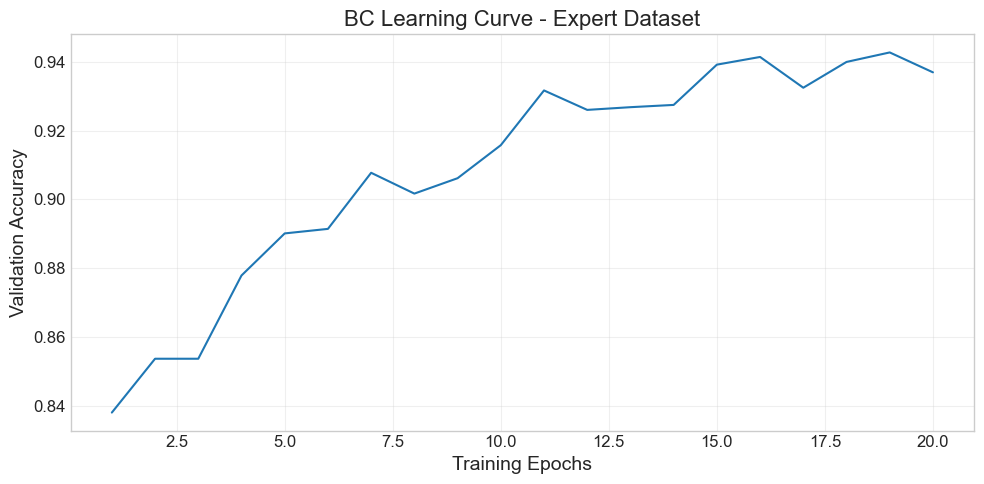

Evaluating final Expert policy...
Episode 1: Reward = 355.0
Episode 6: Reward = 245.0
Episode 11: Reward = 358.0
Episode 16: Reward = 342.0
Average Reward: 402.65 ± 73.72

==================== BC Model on Mixed Dataset ====================
Loaded dataset with 2180 transitions
Action distribution: [1082 1098]
Training set: 1744 samples
Validation set: 436 samples
Epoch 1/20, Loss: 0.6881, Accuracy: 0.6353
Epoch 2/20, Loss: 0.6773, Accuracy: 0.6583
Epoch 3/20, Loss: 0.6707, Accuracy: 0.6674
Epoch 4/20, Loss: 0.6565, Accuracy: 0.6628
Epoch 5/20, Loss: 0.6438, Accuracy: 0.6560
Epoch 6/20, Loss: 0.6254, Accuracy: 0.6743
Epoch 7/20, Loss: 0.6110, Accuracy: 0.6445
Epoch 8/20, Loss: 0.5987, Accuracy: 0.6651
Epoch 9/20, Loss: 0.5925, Accuracy: 0.6858
Epoch 10/20, Loss: 0.5746, Accuracy: 0.6697
Epoch 11/20, Loss: 0.5692, Accuracy: 0.6720
Epoch 12/20, Loss: 0.5566, Accuracy: 0.6858
Epoch 13/20, Loss: 0.5554, Accuracy: 0.6766
Epoch 14/20, Loss: 0.5486, Accuracy: 0.6904
Epoch 15/20, Loss: 0.5459, A

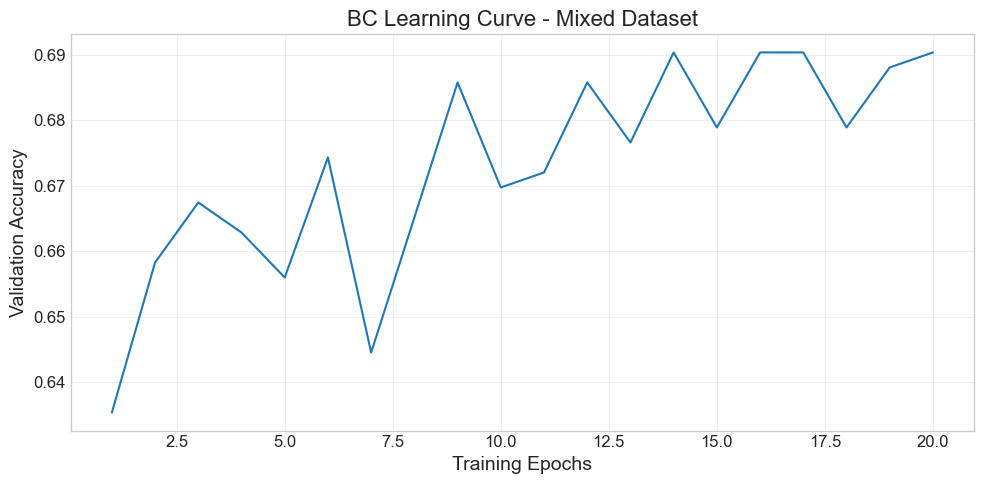

Evaluating final Mixed policy...
Episode 1: Reward = 9.0
Episode 6: Reward = 11.0
Episode 11: Reward = 273.0
Episode 16: Reward = 173.0
Average Reward: 137.35 ± 110.35

==================== BC Model on Random Dataset ====================
Loaded dataset with 2181 transitions
Action distribution: [1086 1095]
Training set: 1744 samples
Validation set: 437 samples
Epoch 1/20, Loss: 0.6971, Accuracy: 0.4874
Epoch 2/20, Loss: 0.6939, Accuracy: 0.4737
Epoch 3/20, Loss: 0.6932, Accuracy: 0.5149
Epoch 4/20, Loss: 0.6933, Accuracy: 0.5378
Epoch 5/20, Loss: 0.6927, Accuracy: 0.5309
Epoch 6/20, Loss: 0.6929, Accuracy: 0.5034
Epoch 7/20, Loss: 0.6944, Accuracy: 0.4874
Epoch 8/20, Loss: 0.6920, Accuracy: 0.5423
Epoch 9/20, Loss: 0.6937, Accuracy: 0.5172
Epoch 10/20, Loss: 0.6921, Accuracy: 0.5400
Epoch 11/20, Loss: 0.6942, Accuracy: 0.5217
Epoch 12/20, Loss: 0.6916, Accuracy: 0.5057
Epoch 13/20, Loss: 0.6918, Accuracy: 0.5172
Epoch 14/20, Loss: 0.6919, Accuracy: 0.5240
Epoch 15/20, Loss: 0.6912, Acc

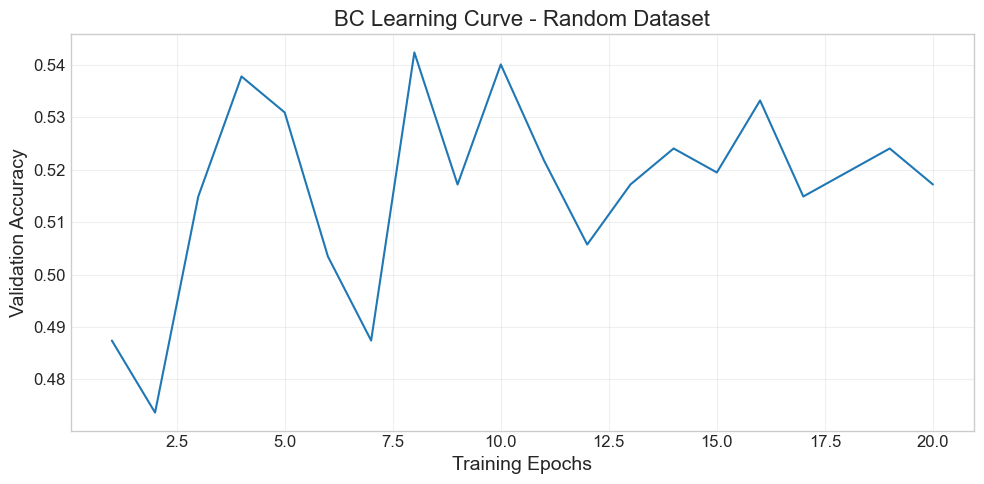

Evaluating final Random policy...
Episode 1: Reward = 29.0
Episode 6: Reward = 16.0
Episode 11: Reward = 22.0
Episode 16: Reward = 17.0
Average Reward: 21.05 ± 4.53

BEHAVIOR CLONING RESULTS SUMMARY
+-----------+--------------------+----------------+-----------------+
| Dataset   | Avg Reward ± Std   | Val Accuracy   | Training Time   |
+===========+====================+================+=================+
| Expert    | 402.65 ± 73.72     | 93.70%         | 5.25s           |
+-----------+--------------------+----------------+-----------------+
| Mixed     | 137.35 ± 110.35    | 69.04%         | 0.31s           |
+-----------+--------------------+----------------+-----------------+
| Random    | 21.05 ± 4.53       | 51.72%         | 0.35s           |
+-----------+--------------------+----------------+-----------------+


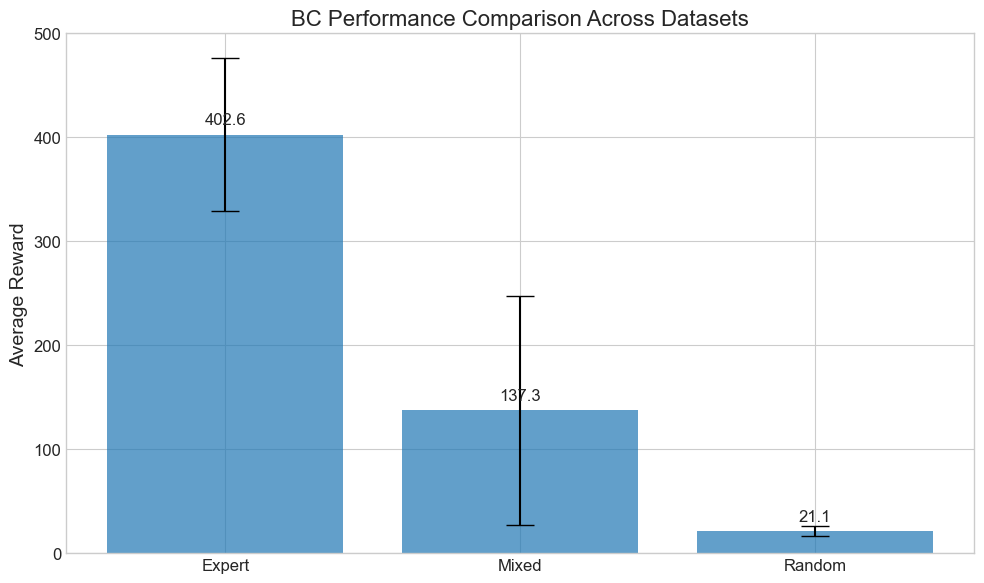

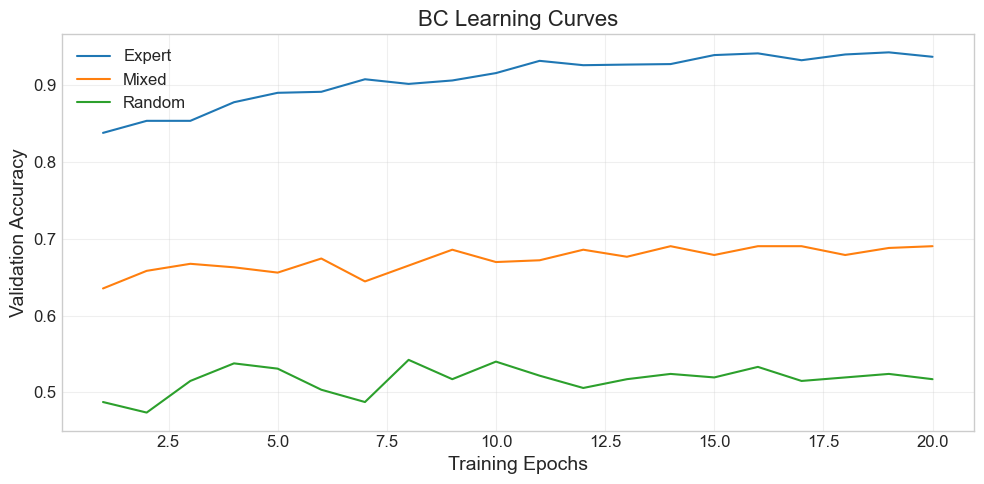

In [31]:
bc_results = run_bc_experiments()




RUNNING OFFLINE DQN EXPERIMENTS

==================== Offline DQN on Expert Dataset ====================
Loaded dataset with 37949 transitions
Action distribution: [19266 18683]
Starting Offline DQN training...


  0%|          | 0/10000 [00:00<?, ?it/s]

Update 500/10000, Avg. Reward: 9.60
Update 1000/10000, Avg. Reward: 10.00
Update 1500/10000, Avg. Reward: 9.20
Update 2000/10000, Avg. Reward: 10.00
Update 2500/10000, Avg. Reward: 9.40
Update 3000/10000, Avg. Reward: 9.40
Update 3500/10000, Avg. Reward: 9.20
Update 4000/10000, Avg. Reward: 9.00
Update 4500/10000, Avg. Reward: 9.80
Update 5000/10000, Avg. Reward: 9.20
Update 5500/10000, Avg. Reward: 9.40
Update 6000/10000, Avg. Reward: 9.80
Update 6500/10000, Avg. Reward: 9.40
Update 7000/10000, Avg. Reward: 9.60
Update 7500/10000, Avg. Reward: 9.60
Update 8000/10000, Avg. Reward: 8.80
Update 8500/10000, Avg. Reward: 8.80
Update 9000/10000, Avg. Reward: 9.60
Update 9500/10000, Avg. Reward: 9.00
Update 10000/10000, Avg. Reward: 9.40


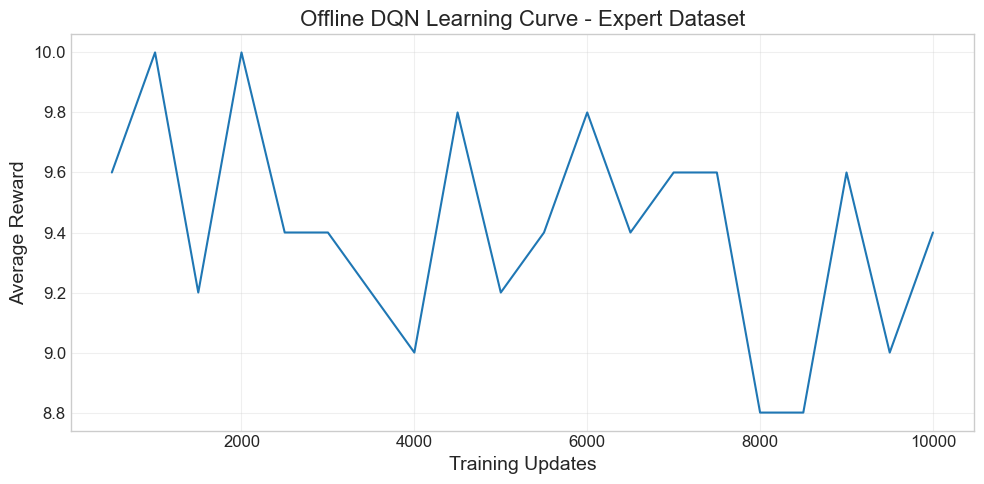

Evaluating final Expert policy...
Episode 1: Reward = 10.0
Episode 2: Reward = 10.0
Episode 3: Reward = 10.0
Episode 4: Reward = 10.0
Episode 5: Reward = 10.0
Episode 6: Reward = 10.0
Episode 7: Reward = 8.0
Episode 8: Reward = 8.0
Episode 9: Reward = 9.0
Episode 10: Reward = 10.0
Episode 11: Reward = 8.0
Episode 12: Reward = 10.0
Episode 13: Reward = 9.0
Episode 14: Reward = 10.0
Episode 15: Reward = 10.0
Episode 16: Reward = 10.0
Episode 17: Reward = 9.0
Episode 18: Reward = 9.0
Episode 19: Reward = 10.0
Episode 20: Reward = 9.0

Average Reward over 20 episodes: 9.45 ± 0.74

==================== Offline DQN on Mixed Dataset ====================
Loaded dataset with 2180 transitions
Action distribution: [1082 1098]
Starting Offline DQN training...


  0%|          | 0/10000 [00:00<?, ?it/s]

Update 500/10000, Avg. Reward: 60.40
Update 1000/10000, Avg. Reward: 123.60
Update 1500/10000, Avg. Reward: 202.60
Update 2000/10000, Avg. Reward: 220.80
Update 2500/10000, Avg. Reward: 229.40
Update 3000/10000, Avg. Reward: 252.00
Update 3500/10000, Avg. Reward: 245.60
Update 4000/10000, Avg. Reward: 318.00
Update 4500/10000, Avg. Reward: 241.40
Update 5000/10000, Avg. Reward: 321.00
Update 5500/10000, Avg. Reward: 290.00
Update 6000/10000, Avg. Reward: 236.40
Update 6500/10000, Avg. Reward: 276.60
Update 7000/10000, Avg. Reward: 232.80
Update 7500/10000, Avg. Reward: 221.00
Update 8000/10000, Avg. Reward: 224.00
Update 8500/10000, Avg. Reward: 223.80
Update 9000/10000, Avg. Reward: 259.60
Update 9500/10000, Avg. Reward: 472.80
Update 10000/10000, Avg. Reward: 463.60


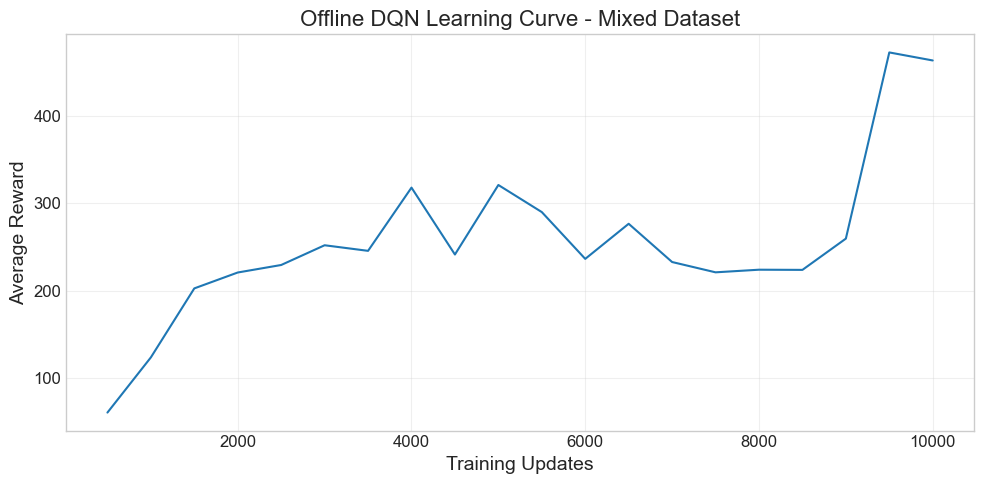

Evaluating final Mixed policy...
Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 340.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Episode 6: Reward = 480.0
Episode 7: Reward = 500.0
Episode 8: Reward = 371.0
Episode 9: Reward = 429.0
Episode 10: Reward = 500.0
Episode 11: Reward = 320.0
Episode 12: Reward = 500.0
Episode 13: Reward = 500.0
Episode 14: Reward = 292.0
Episode 15: Reward = 500.0
Episode 16: Reward = 397.0
Episode 17: Reward = 500.0
Episode 18: Reward = 286.0
Episode 19: Reward = 351.0
Episode 20: Reward = 453.0

Average Reward over 20 episodes: 435.95 ± 78.14

==================== Offline DQN on Random Dataset ====================
Loaded dataset with 2181 transitions
Action distribution: [1086 1095]
Starting Offline DQN training...


  0%|          | 0/10000 [00:00<?, ?it/s]

Update 500/10000, Avg. Reward: 70.40
Update 1000/10000, Avg. Reward: 233.40
Update 1500/10000, Avg. Reward: 219.80
Update 2000/10000, Avg. Reward: 171.20
Update 2500/10000, Avg. Reward: 198.80
Update 3000/10000, Avg. Reward: 223.00
Update 3500/10000, Avg. Reward: 235.40
Update 4000/10000, Avg. Reward: 256.80
Update 4500/10000, Avg. Reward: 313.40
Update 5000/10000, Avg. Reward: 187.20
Update 5500/10000, Avg. Reward: 260.00
Update 6000/10000, Avg. Reward: 196.80
Update 6500/10000, Avg. Reward: 265.20
Update 7000/10000, Avg. Reward: 252.40
Update 7500/10000, Avg. Reward: 303.60
Update 8000/10000, Avg. Reward: 300.00
Update 8500/10000, Avg. Reward: 212.60
Update 9000/10000, Avg. Reward: 214.40
Update 9500/10000, Avg. Reward: 251.80
Update 10000/10000, Avg. Reward: 221.40


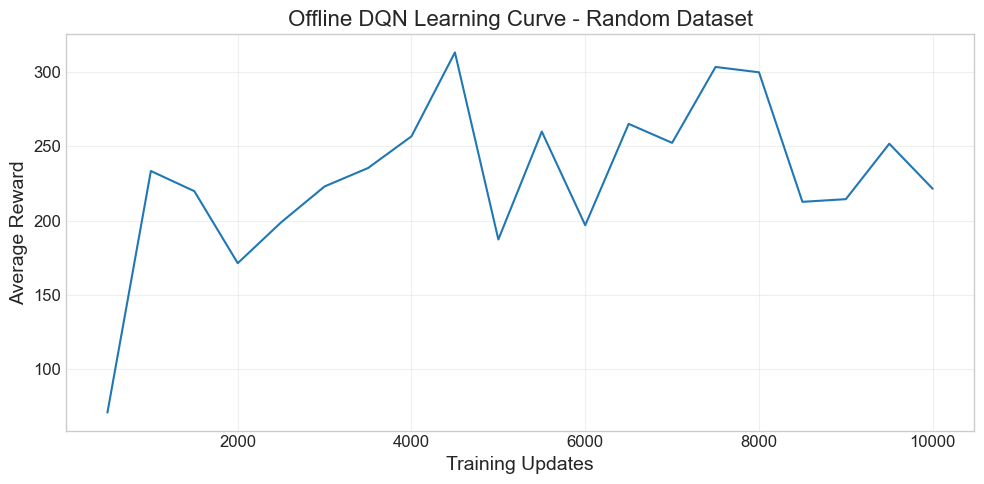

Evaluating final Random policy...
Episode 1: Reward = 195.0
Episode 2: Reward = 208.0
Episode 3: Reward = 175.0
Episode 4: Reward = 184.0
Episode 5: Reward = 193.0
Episode 6: Reward = 190.0
Episode 7: Reward = 217.0
Episode 8: Reward = 171.0
Episode 9: Reward = 267.0
Episode 10: Reward = 283.0
Episode 11: Reward = 343.0
Episode 12: Reward = 253.0
Episode 13: Reward = 285.0
Episode 14: Reward = 177.0
Episode 15: Reward = 279.0
Episode 16: Reward = 229.0
Episode 17: Reward = 231.0
Episode 18: Reward = 166.0
Episode 19: Reward = 310.0
Episode 20: Reward = 177.0

Average Reward over 20 episodes: 226.65 ± 51.12

OFFLINE DQN RESULTS SUMMARY
+-----------+--------------------+-----------------+
| Dataset   | Avg Reward ± Std   | Training Time   |
+===========+====================+=================+
| Expert    | 9.45 ± 0.74        | 5.41s           |
+-----------+--------------------+-----------------+
| Mixed     | 435.95 ± 78.14     | 6.38s           |
+-----------+--------------------+-----

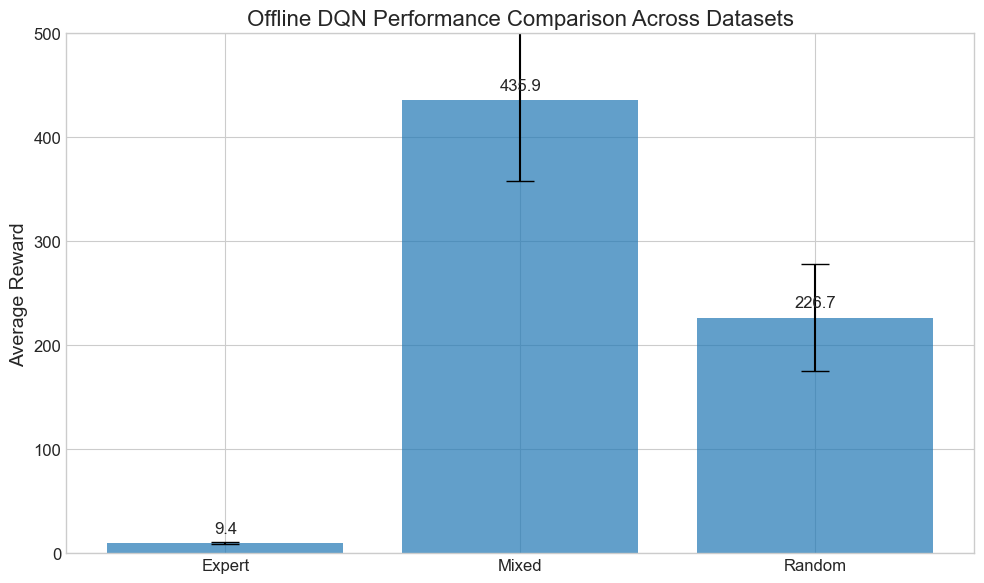

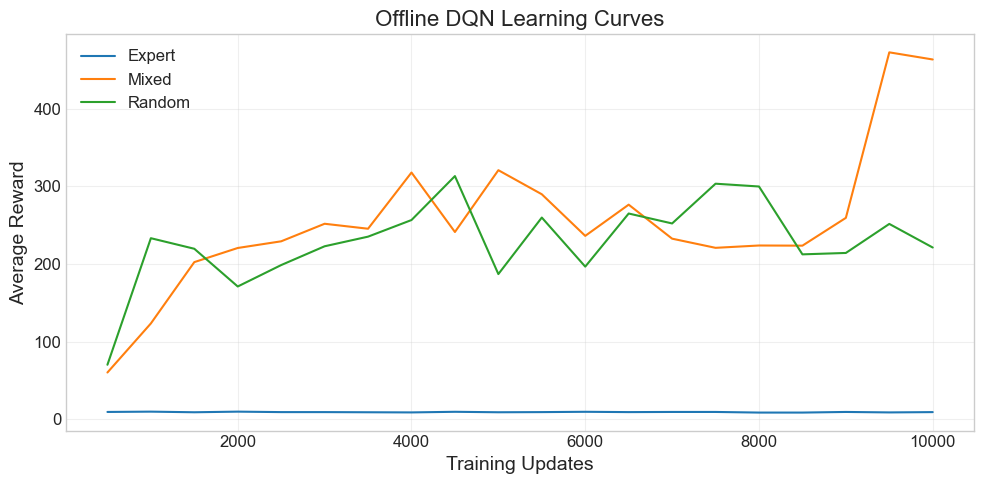

In [ ]:
dqn_results = run_offline_dqn_experiments()



RUNNING CONSERVATIVE Q-LEARNING EXPERIMENTS

==================== Training CQL on Expert Dataset ====================
Loading dataset from expert_data.npz
Dataset contains 37949 transitions
Action distribution: [19266 18683]
Training CQL on Expert dataset...
2025-04-20 17:23:22 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:22 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20250420172322
2025-04-20 17:23:22 [debug    ] Building models...            
2025-04-20 17:23:22 [debug    ] Models have been built.       
2025-04-20 17:23:22 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:26 [info     ] DiscreteCQL_20250420172322: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001242544651031494, 'time_algorithm_update': 0.002726695775985718, 'loss': array([0.5919079, 0.5275631], dtype=float32), 'time_step': 0.004004992008209228} step=1000
2025-04-20 17:23:26 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172322/model_1000.d3
Episode 1: Reward = 193.0
Episode 2: Reward = 246.0
Episode 3: Reward = 146.0
Episode 4: Reward = 248.0
Episode 5: Reward = 194.0
Average return: 205.40 ± 38.14
Step 1000/20000, Avg Reward: 205.40
2025-04-20 17:23:26 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:26 [info     ] Directory is created a

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:30 [info     ] DiscreteCQL_20250420172326: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012500398159027099, 'time_algorithm_update': 0.002799637317657471, 'loss': array([0.47241512, 0.42365018], dtype=float32), 'time_step': 0.004079070806503296} step=1000
2025-04-20 17:23:30 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172326/model_1000.d3
Episode 1: Reward = 270.0
Episode 2: Reward = 285.0
Episode 3: Reward = 252.0
Episode 4: Reward = 289.0
Episode 5: Reward = 331.0
Average return: 285.40 ± 26.25
Step 2000/20000, Avg Reward: 285.40
2025-04-20 17:23:30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:30 [info     ] Directory is create

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:34 [info     ] DiscreteCQL_20250420172330: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001251600742340088, 'time_algorithm_update': 0.002686557054519653, 'loss': array([0.4276285 , 0.38466895], dtype=float32), 'time_step': 0.003965923070907593} step=1000
2025-04-20 17:23:34 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172330/model_1000.d3
Episode 1: Reward = 276.0
Episode 2: Reward = 500.0
Episode 3: Reward = 466.0
Episode 4: Reward = 500.0
Episode 5: Reward = 312.0
Average return: 410.80 ± 96.84
Step 3000/20000, Avg Reward: 410.80
2025-04-20 17:23:34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:34 [info     ] Directory is created

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:39 [info     ] DiscreteCQL_20250420172334: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012745993137359619, 'time_algorithm_update': 0.0029170560836791993, 'loss': array([0.39448202, 0.3577507 ], dtype=float32), 'time_step': 0.004221859455108642} step=1000
2025-04-20 17:23:39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172334/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 315.0
Episode 3: Reward = 368.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Average return: 436.60 ± 79.44
Step 4000/20000, Avg Reward: 436.60
2025-04-20 17:23:39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:39 [info     ] Directory is creat

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:43 [info     ] DiscreteCQL_20250420172339: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012421298027038574, 'time_algorithm_update': 0.0027740681171417236, 'loss': array([0.36835247, 0.33500817], dtype=float32), 'time_step': 0.004044163703918457} step=1000
2025-04-20 17:23:43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172339/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 382.0
Episode 5: Reward = 361.0
Average return: 448.60 ± 63.30
Step 5000/20000, Avg Reward: 448.60
2025-04-20 17:23:43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:43 [info     ] Directory is creat

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:47 [info     ] DiscreteCQL_20250420172343: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012474453449249267, 'time_algorithm_update': 0.002793344497680664, 'loss': array([0.3512976 , 0.31871003], dtype=float32), 'time_step': 0.004069721221923828} step=1000
2025-04-20 17:23:47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172343/model_1000.d3
Episode 1: Reward = 296.0
Episode 2: Reward = 500.0
Episode 3: Reward = 301.0
Episode 4: Reward = 317.0
Episode 5: Reward = 361.0
Average return: 355.00 ± 76.03
Step 6000/20000, Avg Reward: 355.00
2025-04-20 17:23:47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:47 [info     ] Directory is create

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:51 [info     ] DiscreteCQL_20250420172347: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001237078905105591, 'time_algorithm_update': 0.0026691787242889404, 'loss': array([0.3361371 , 0.30354685], dtype=float32), 'time_step': 0.003932697772979736} step=1000
2025-04-20 17:23:51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172347/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 287.0
Episode 3: Reward = 431.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Average return: 443.60 ± 82.73
Step 7000/20000, Avg Reward: 443.60
2025-04-20 17:23:52 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:52 [info     ] Directory is create

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:55 [info     ] DiscreteCQL_20250420172352: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001211353302001953, 'time_algorithm_update': 0.002629724025726318, 'loss': array([0.32544315, 0.2933242 ], dtype=float32), 'time_step': 0.0038653836250305174} step=1000
2025-04-20 17:23:55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172352/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 353.0
Average return: 470.60 ± 58.80
Step 8000/20000, Avg Reward: 470.60
2025-04-20 17:23:56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:23:56 [info     ] Directory is create

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:23:59 [info     ] DiscreteCQL_20250420172356: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011541426181793212, 'time_algorithm_update': 0.002509490251541138, 'loss': array([0.33043426, 0.28464654], dtype=float32), 'time_step': 0.0036859493255615235} step=1000
2025-04-20 17:23:59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172356/model_1000.d3
Episode 1: Reward = 370.0
Episode 2: Reward = 386.0
Episode 3: Reward = 500.0
Episode 4: Reward = 374.0
Episode 5: Reward = 500.0
Average return: 426.00 ± 60.65
Step 9000/20000, Avg Reward: 426.00
2025-04-20 17:24:00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:00 [info     ] Directory is creat

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:03 [info     ] DiscreteCQL_20250420172400: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011283781528472901, 'time_algorithm_update': 0.0024027643203735354, 'loss': array([0.31658268, 0.2770647 ], dtype=float32), 'time_step': 0.0035502147674560548} step=1000
2025-04-20 17:24:03 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172400/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 362.0
Episode 3: Reward = 307.0
Episode 4: Reward = 362.0
Episode 5: Reward = 500.0
Average return: 406.20 ± 79.18
Step 10000/20000, Avg Reward: 406.20
2025-04-20 17:24:03 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:03 [info     ] Directory is cre

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:07 [info     ] DiscreteCQL_20250420172403: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011846323013305663, 'time_algorithm_update': 0.00263539719581604, 'loss': array([0.30862615, 0.2695963 ], dtype=float32), 'time_step': 0.003842777967453003} step=1000
2025-04-20 17:24:07 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172403/model_1000.d3
Episode 1: Reward = 353.0
Episode 2: Reward = 475.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 299.0
Average return: 425.40 ± 83.44
Step 11000/20000, Avg Reward: 425.40
2025-04-20 17:24:07 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:07 [info     ] Directory is create

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:11 [info     ] DiscreteCQL_20250420172407: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012092607021331786, 'time_algorithm_update': 0.002628430366516113, 'loss': array([0.30309063, 0.26375645], dtype=float32), 'time_step': 0.0038626692295074465} step=1000
2025-04-20 17:24:11 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172407/model_1000.d3
Episode 1: Reward = 480.0
Episode 2: Reward = 305.0
Episode 3: Reward = 325.0
Episode 4: Reward = 355.0
Episode 5: Reward = 500.0
Average return: 393.00 ± 81.03
Step 12000/20000, Avg Reward: 393.00
2025-04-20 17:24:12 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:12 [info     ] Directory is crea

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:16 [info     ] DiscreteCQL_20250420172412: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001216468095779419, 'time_algorithm_update': 0.0027573018074035643, 'loss': array([0.2963446, 0.2572655], dtype=float32), 'time_step': 0.003999814510345459} step=1000
2025-04-20 17:24:16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172412/model_1000.d3
Episode 1: Reward = 296.0
Episode 2: Reward = 335.0
Episode 3: Reward = 330.0
Episode 4: Reward = 355.0
Episode 5: Reward = 489.0
Average return: 361.00 ± 66.76
Step 13000/20000, Avg Reward: 361.00
2025-04-20 17:24:16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:16 [info     ] Directory is created

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:19 [info     ] DiscreteCQL_20250420172416: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011470043659210206, 'time_algorithm_update': 0.0024093241691589356, 'loss': array([0.29141742, 0.2514369 ], dtype=float32), 'time_step': 0.0035775146484375} step=1000
2025-04-20 17:24:19 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172416/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 326.0
Episode 5: Reward = 500.0
Average return: 465.20 ± 69.60
Step 14000/20000, Avg Reward: 465.20
2025-04-20 17:24:20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:20 [info     ] Directory is create

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:25 [info     ] DiscreteCQL_20250420172420: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0014071898460388183, 'time_algorithm_update': 0.004091537714004516, 'loss': array([0.28648493, 0.2461931 ], dtype=float32), 'time_step': 0.005534136056900024} step=1000
2025-04-20 17:24:25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172420/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 341.0
Episode 3: Reward = 500.0
Episode 4: Reward = 500.0
Episode 5: Reward = 500.0
Average return: 468.20 ± 63.60
Step 15000/20000, Avg Reward: 468.20
2025-04-20 17:24:25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:25 [info     ] Directory is creat

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:29 [info     ] DiscreteCQL_20250420172425: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012265541553497315, 'time_algorithm_update': 0.002671616554260254, 'loss': array([0.2820015 , 0.24174352], dtype=float32), 'time_step': 0.003926345348358154} step=1000
2025-04-20 17:24:29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172425/model_1000.d3
Episode 1: Reward = 322.0
Episode 2: Reward = 500.0
Episode 3: Reward = 500.0
Episode 4: Reward = 347.0
Episode 5: Reward = 500.0
Average return: 433.80 ± 81.46
Step 16000/20000, Avg Reward: 433.80
2025-04-20 17:24:30 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:30 [info     ] Directory is creat

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:33 [info     ] DiscreteCQL_20250420172430: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011872777938842774, 'time_algorithm_update': 0.0026016027927398683, 'loss': array([0.28407615, 0.23822978], dtype=float32), 'time_step': 0.0038120520114898683} step=1000
2025-04-20 17:24:33 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172430/model_1000.d3
Episode 1: Reward = 410.0
Episode 2: Reward = 305.0
Episode 3: Reward = 450.0
Episode 4: Reward = 305.0
Episode 5: Reward = 336.0
Average return: 361.20 ± 58.68
Step 17000/20000, Avg Reward: 361.20
2025-04-20 17:24:34 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:34 [info     ] Directory is cre

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:38 [info     ] DiscreteCQL_20250420172434: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012689402103424072, 'time_algorithm_update': 0.0028587067127227783, 'loss': array([0.273672  , 0.23176101], dtype=float32), 'time_step': 0.0041593024730682375} step=1000
2025-04-20 17:24:38 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172434/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 479.0
Episode 3: Reward = 287.0
Episode 4: Reward = 500.0
Episode 5: Reward = 292.0
Average return: 411.60 ± 100.00
Step 18000/20000, Avg Reward: 411.60
2025-04-20 17:24:38 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:38 [info     ] Directory is cr

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:42 [info     ] DiscreteCQL_20250420172438: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012387592792510987, 'time_algorithm_update': 0.0026417787075042726, 'loss': array([0.26912877, 0.22711116], dtype=float32), 'time_step': 0.003906418085098267} step=1000
2025-04-20 17:24:42 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172438/model_1000.d3
Episode 1: Reward = 336.0
Episode 2: Reward = 451.0
Episode 3: Reward = 283.0
Episode 4: Reward = 372.0
Episode 5: Reward = 500.0
Average return: 388.40 ± 78.10
Step 19000/20000, Avg Reward: 388.40
2025-04-20 17:24:42 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:42 [info     ] Directory is crea

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:46 [info     ] DiscreteCQL_20250420172442: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012578339576721192, 'time_algorithm_update': 0.0028079915046691894, 'loss': array([0.26672664, 0.22503872], dtype=float32), 'time_step': 0.0040959868431091305} step=1000
2025-04-20 17:24:46 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172442/model_1000.d3
Episode 1: Reward = 500.0
Episode 2: Reward = 313.0
Episode 3: Reward = 359.0
Episode 4: Reward = 435.0
Episode 5: Reward = 355.0
Average return: 392.40 ± 66.65
Step 20000/20000, Avg Reward: 392.40
Evaluating final Expert policy...
Episode 1: Reward = 333.0
Episode 2: Reward = 313.0
Episode 3: Reward = 420.0
Episode 4: Reward = 319.0
Episode 5: Reward = 343.0
Episode 6: Reward = 327.0
Episode 7: Reward = 500.0
Episode 8: Reward = 256.0
Episode 9: Reward = 500.0
Episode 10: Reward = 350.0
Episode 11: Reward = 307.0
Episode 12: Reward = 330.0
Episode 13: Reward = 310.0
Episode 14: Reward = 5

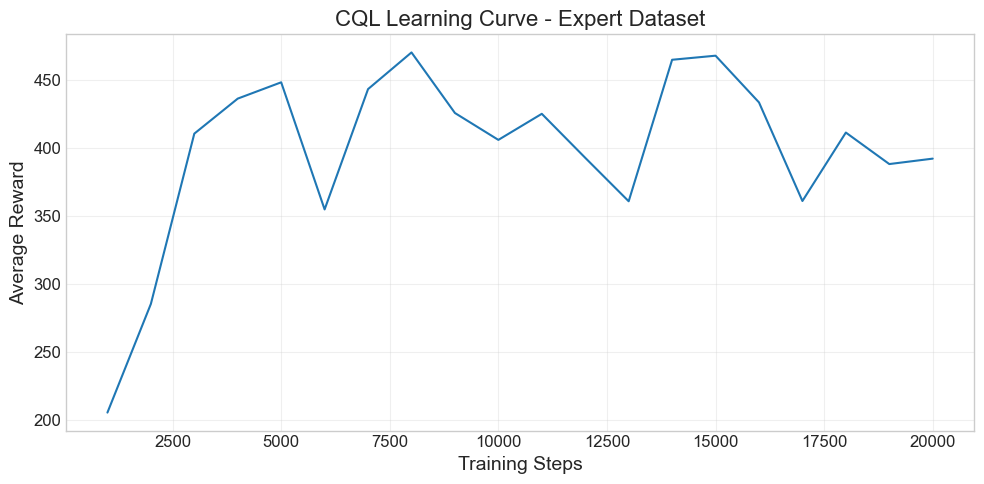


==================== Training CQL on Mixed Dataset ====================
Loading dataset from mixed_data.npz
Dataset contains 2180 transitions
Action distribution: [1082 1098]
Training CQL on Mixed dataset...
2025-04-20 17:24:47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:47 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20250420172447
2025-04-20 17:24:47 [debug    ] Building models...            
2025-04-20 17:24:47 [debug    ] Models have been built.       
2025-04-20 17:24:47 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': {'t

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:51 [info     ] DiscreteCQL_20250420172447: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0012068812847137451, 'time_algorithm_update': 0.002668905735015869, 'loss': array([0.69745624, 0.66266626], dtype=float32), 'time_step': 0.003909191846847534} step=1000
2025-04-20 17:24:51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172447/model_1000.d3
Episode 1: Reward = 81.0
Episode 2: Reward = 86.0
Episode 3: Reward = 111.0
Episode 4: Reward = 71.0
Episode 5: Reward = 113.0
Average return: 92.40 ± 16.73
Step 1000/20000, Avg Reward: 92.40
2025-04-20 17:24:51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:51 [info     ] Directory is created at 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:24:56 [info     ] DiscreteCQL_20250420172451: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011793978214263915, 'time_algorithm_update': 0.003548426628112793, 'loss': array([0.62161356, 0.6025774 ], dtype=float32), 'time_step': 0.004755077600479126} step=1000
2025-04-20 17:24:56 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172451/model_1000.d3
Episode 1: Reward = 129.0
Episode 2: Reward = 226.0
Episode 3: Reward = 115.0
Episode 4: Reward = 133.0
Episode 5: Reward = 125.0
Average return: 145.60 ± 40.64
Step 2000/20000, Avg Reward: 145.60
2025-04-20 17:24:56 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:24:56 [info     ] Directory is create

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:00 [info     ] DiscreteCQL_20250420172456: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011692640781402587, 'time_algorithm_update': 0.0027484936714172363, 'loss': array([0.59968996, 0.5729305 ], dtype=float32), 'time_step': 0.003944165229797363} step=1000
2025-04-20 17:25:00 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172456/model_1000.d3
Episode 1: Reward = 129.0
Episode 2: Reward = 262.0
Episode 3: Reward = 132.0
Episode 4: Reward = 121.0
Episode 5: Reward = 165.0
Average return: 161.80 ± 52.30
Step 3000/20000, Avg Reward: 161.80
2025-04-20 17:25:00 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:00 [info     ] Directory is creat

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:05 [info     ] DiscreteCQL_20250420172500: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011521658897399902, 'time_algorithm_update': 0.0033006525039672853, 'loss': array([0.5885316, 0.5602412], dtype=float32), 'time_step': 0.0044773705005645755} step=1000
2025-04-20 17:25:05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172500/model_1000.d3
Episode 1: Reward = 10.0
Episode 2: Reward = 23.0
Episode 3: Reward = 10.0
Episode 4: Reward = 179.0
Episode 5: Reward = 9.0
Average return: 46.20 ± 66.60
Step 4000/20000, Avg Reward: 46.20
2025-04-20 17:25:05 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:05 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:09 [info     ] DiscreteCQL_20250420172505: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011243293285369874, 'time_algorithm_update': 0.0028599021434783938, 'loss': array([0.57960266, 0.55185443], dtype=float32), 'time_step': 0.004006524562835693} step=1000
2025-04-20 17:25:09 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172505/model_1000.d3
Episode 1: Reward = 137.0
Episode 2: Reward = 9.0
Episode 3: Reward = 258.0
Episode 4: Reward = 289.0
Episode 5: Reward = 179.0
Average return: 174.40 ± 98.89
Step 5000/20000, Avg Reward: 174.40
2025-04-20 17:25:09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:09 [info     ] Directory is created

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:12 [info     ] DiscreteCQL_20250420172509: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011240153312683107, 'time_algorithm_update': 0.002478661060333252, 'loss': array([0.5710968, 0.5439243], dtype=float32), 'time_step': 0.0036256015300750732} step=1000
2025-04-20 17:25:12 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172509/model_1000.d3
Episode 1: Reward = 9.0
Episode 2: Reward = 129.0
Episode 3: Reward = 9.0
Episode 4: Reward = 171.0
Episode 5: Reward = 169.0
Average return: 97.40 ± 73.72
Step 6000/20000, Avg Reward: 97.40
2025-04-20 17:25:13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:13 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:16 [info     ] DiscreteCQL_20250420172513: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011303913593292236, 'time_algorithm_update': 0.0024601757526397706, 'loss': array([0.5628372 , 0.53647196], dtype=float32), 'time_step': 0.003612471342086792} step=1000
2025-04-20 17:25:16 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172513/model_1000.d3
Episode 1: Reward = 12.0
Episode 2: Reward = 81.0
Episode 3: Reward = 10.0
Episode 4: Reward = 9.0
Episode 5: Reward = 178.0
Average return: 58.00 ± 65.95
Step 7000/20000, Avg Reward: 58.00
2025-04-20 17:25:16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:16 [info     ] Directory is created at d

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:20 [info     ] DiscreteCQL_20250420172516: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011796684265136719, 'time_algorithm_update': 0.0026781110763549804, 'loss': array([0.55726814, 0.5313216 ], dtype=float32), 'time_step': 0.003884920120239258} step=1000
2025-04-20 17:25:20 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172516/model_1000.d3
Episode 1: Reward = 163.0
Episode 2: Reward = 10.0
Episode 3: Reward = 36.0
Episode 4: Reward = 8.0
Episode 5: Reward = 500.0
Average return: 143.40 ± 187.20
Step 8000/20000, Avg Reward: 143.40
2025-04-20 17:25:20 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:20 [info     ] Directory is created 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:24 [info     ] DiscreteCQL_20250420172520: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011659953594207763, 'time_algorithm_update': 0.002643441438674927, 'loss': array([0.571157  , 0.52633804], dtype=float32), 'time_step': 0.003836787223815918} step=1000
2025-04-20 17:25:24 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172520/model_1000.d3
Episode 1: Reward = 16.0
Episode 2: Reward = 54.0
Episode 3: Reward = 161.0
Episode 4: Reward = 10.0
Episode 5: Reward = 193.0
Average return: 86.80 ± 75.86
Step 9000/20000, Avg Reward: 86.80
2025-04-20 17:25:24 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:24 [info     ] Directory is created at 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:28 [info     ] DiscreteCQL_20250420172524: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001156658172607422, 'time_algorithm_update': 0.002571653127670288, 'loss': array([0.5609955, 0.5230549], dtype=float32), 'time_step': 0.0037531447410583496} step=1000
2025-04-20 17:25:28 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172524/model_1000.d3
Episode 1: Reward = 66.0
Episode 2: Reward = 21.0
Episode 3: Reward = 25.0
Episode 4: Reward = 40.0
Episode 5: Reward = 8.0
Average return: 32.00 ± 19.83
Step 10000/20000, Avg Reward: 32.00
2025-04-20 17:25:28 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:28 [info     ] Directory is created at d3rl

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:32 [info     ] DiscreteCQL_20250420172528: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011467940807342529, 'time_algorithm_update': 0.002499002933502197, 'loss': array([0.5570612 , 0.52001774], dtype=float32), 'time_step': 0.0036685972213745116} step=1000
2025-04-20 17:25:32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172528/model_1000.d3
Episode 1: Reward = 168.0
Episode 2: Reward = 8.0
Episode 3: Reward = 11.0
Episode 4: Reward = 185.0
Episode 5: Reward = 161.0
Average return: 106.60 ± 79.67
Step 11000/20000, Avg Reward: 106.60
2025-04-20 17:25:32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:32 [info     ] Directory is created

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:35 [info     ] DiscreteCQL_20250420172532: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001156013011932373, 'time_algorithm_update': 0.0025207126140594483, 'loss': array([0.55368185, 0.5171109 ], dtype=float32), 'time_step': 0.003702001094818115} step=1000
2025-04-20 17:25:35 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172532/model_1000.d3
Episode 1: Reward = 20.0
Episode 2: Reward = 8.0
Episode 3: Reward = 10.0
Episode 4: Reward = 11.0
Episode 5: Reward = 38.0
Average return: 17.40 ± 11.09
Step 12000/20000, Avg Reward: 17.40
2025-04-20 17:25:35 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:35 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:39 [info     ] DiscreteCQL_20250420172535: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011625843048095703, 'time_algorithm_update': 0.0025240046977996825, 'loss': array([0.5514348, 0.5152165], dtype=float32), 'time_step': 0.0037113850116729736} step=1000
2025-04-20 17:25:39 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172535/model_1000.d3
Episode 1: Reward = 27.0
Episode 2: Reward = 500.0
Episode 3: Reward = 181.0
Episode 4: Reward = 10.0
Episode 5: Reward = 10.0
Average return: 145.60 ± 188.52
Step 13000/20000, Avg Reward: 145.60
2025-04-20 17:25:39 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:39 [info     ] Directory is created

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:43 [info     ] DiscreteCQL_20250420172539: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011784129142761231, 'time_algorithm_update': 0.0026916680335998537, 'loss': array([0.5460686 , 0.51055473], dtype=float32), 'time_step': 0.0038966250419616697} step=1000
2025-04-20 17:25:43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172539/model_1000.d3
Episode 1: Reward = 258.0
Episode 2: Reward = 9.0
Episode 3: Reward = 11.0
Episode 4: Reward = 10.0
Episode 5: Reward = 9.0
Average return: 59.40 ± 99.30
Step 14000/20000, Avg Reward: 59.40
2025-04-20 17:25:43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:43 [info     ] Directory is created at 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:47 [info     ] DiscreteCQL_20250420172543: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011756448745727538, 'time_algorithm_update': 0.002650644063949585, 'loss': array([0.5443292, 0.5091132], dtype=float32), 'time_step': 0.003854712963104248} step=1000
2025-04-20 17:25:47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172543/model_1000.d3
Episode 1: Reward = 11.0
Episode 2: Reward = 191.0
Episode 3: Reward = 13.0
Episode 4: Reward = 10.0
Episode 5: Reward = 18.0
Average return: 48.60 ± 71.25
Step 15000/20000, Avg Reward: 48.60
2025-04-20 17:25:47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:47 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:51 [info     ] DiscreteCQL_20250420172547: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011179399490356444, 'time_algorithm_update': 0.0025552761554718017, 'loss': array([0.5403875, 0.5051986], dtype=float32), 'time_step': 0.0036962363719940184} step=1000
2025-04-20 17:25:51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172547/model_1000.d3
Episode 1: Reward = 12.0
Episode 2: Reward = 11.0
Episode 3: Reward = 32.0
Episode 4: Reward = 28.0
Episode 5: Reward = 34.0
Average return: 23.40 ± 9.91
Step 16000/20000, Avg Reward: 23.40
2025-04-20 17:25:51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:51 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:55 [info     ] DiscreteCQL_20250420172551: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011501860618591308, 'time_algorithm_update': 0.002527981996536255, 'loss': array([0.5655401, 0.5044453], dtype=float32), 'time_step': 0.0037037787437438963} step=1000
2025-04-20 17:25:55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172551/model_1000.d3
Episode 1: Reward = 11.0
Episode 2: Reward = 13.0
Episode 3: Reward = 11.0
Episode 4: Reward = 219.0
Episode 5: Reward = 177.0
Average return: 86.20 ± 92.25
Step 17000/20000, Avg Reward: 86.20
2025-04-20 17:25:55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:55 [info     ] Directory is created at 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:25:58 [info     ] DiscreteCQL_20250420172555: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011484222412109376, 'time_algorithm_update': 0.0026329169273376467, 'loss': array([0.5573837 , 0.50203437], dtype=float32), 'time_step': 0.0038056819438934326} step=1000
2025-04-20 17:25:58 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172555/model_1000.d3
Episode 1: Reward = 10.0
Episode 2: Reward = 27.0
Episode 3: Reward = 10.0
Episode 4: Reward = 10.0
Episode 5: Reward = 39.0
Average return: 19.20 ± 11.89
Step 18000/20000, Avg Reward: 19.20
2025-04-20 17:25:58 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:25:58 [info     ] Directory is created at

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:02 [info     ] DiscreteCQL_20250420172558: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001098348617553711, 'time_algorithm_update': 0.002290201425552368, 'loss': array([0.55446994, 0.4999611 ], dtype=float32), 'time_step': 0.0034074928760528564} step=1000
2025-04-20 17:26:02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172558/model_1000.d3
Episode 1: Reward = 9.0
Episode 2: Reward = 29.0
Episode 3: Reward = 12.0
Episode 4: Reward = 12.0
Episode 5: Reward = 8.0
Average return: 14.00 ± 7.67
Step 19000/20000, Avg Reward: 14.00
2025-04-20 17:26:02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:02 [info     ] Directory is created at d3rl

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:05 [info     ] DiscreteCQL_20250420172602: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011116068363189698, 'time_algorithm_update': 0.0023583481311798098, 'loss': array([0.5498793, 0.4964583], dtype=float32), 'time_step': 0.0034901702404022215} step=1000
2025-04-20 17:26:05 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172602/model_1000.d3
Episode 1: Reward = 149.0
Episode 2: Reward = 10.0
Episode 3: Reward = 24.0
Episode 4: Reward = 11.0
Episode 5: Reward = 9.0
Average return: 40.60 ± 54.47
Step 20000/20000, Avg Reward: 40.60
Evaluating final Mixed policy...
Episode 1: Reward = 193.0
Episode 2: Reward = 10.0
Episode 3: Reward = 10.0
Episode 4: Reward = 8.0
Episode 5: Reward = 261.0
Episode 6: Reward = 48.0
Episode 7: Reward = 210.0
Episode 8: Reward = 119.0
Episode 9: Reward = 13.0
Episode 10: Reward = 9.0
Episode 11: Reward = 184.0
Episode 12: Reward = 9.0
Episode 13: Reward = 189.0
Episode 14: Reward = 307.0
Episode 15: Rew

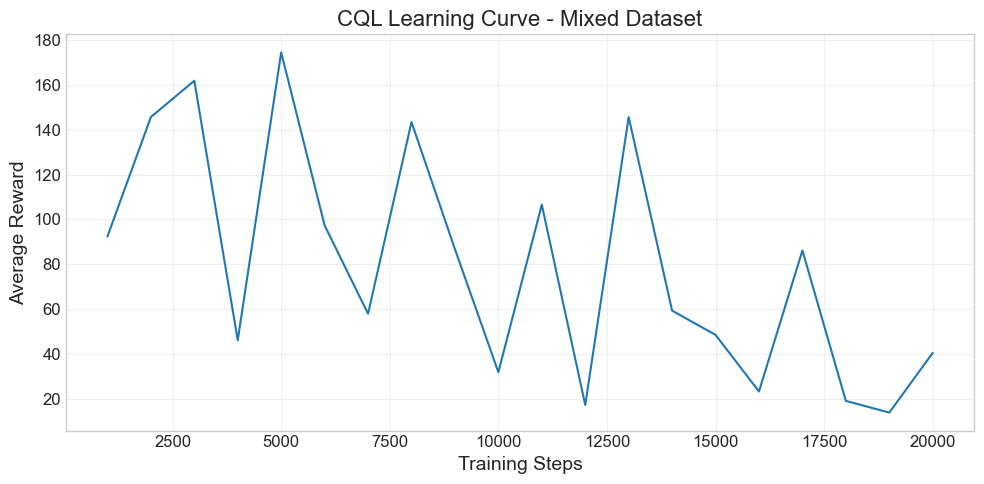


==================== Training CQL on Random Dataset ====================
Loading dataset from random_data.npz
Dataset contains 2181 transitions
Action distribution: [1086 1095]
Training CQL on Random dataset...
2025-04-20 17:26:06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:06 [info     ] Directory is created at d3rlpy_logs/DiscreteCQL_20250420172606
2025-04-20 17:26:06 [debug    ] Building models...            
2025-04-20 17:26:06 [debug    ] Models have been built.       
2025-04-20 17:26:06 [info     ] Parameters                     params={'observation_shape': [4], 'action_size': 2, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 256, 'gamma': 0.99, 'observation_scaler': 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:10 [info     ] DiscreteCQL_20250420172606: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011850111484527587, 'time_algorithm_update': 0.0026368467807769773, 'loss': array([0.7184773, 0.6916425], dtype=float32), 'time_step': 0.0038497123718261718} step=1000
2025-04-20 17:26:10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172606/model_1000.d3
Episode 1: Reward = 9.0
Episode 2: Reward = 10.0
Episode 3: Reward = 10.0
Episode 4: Reward = 10.0
Episode 5: Reward = 8.0
Average return: 9.40 ± 0.80
Step 1000/20000, Avg Reward: 9.40
2025-04-20 17:26:10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:10 [info     ] Directory is created at d3rlpy_

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:13 [info     ] DiscreteCQL_20250420172610: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011535136699676513, 'time_algorithm_update': 0.0024962239265441896, 'loss': array([0.6906159 , 0.68971753], dtype=float32), 'time_step': 0.003672954797744751} step=1000
2025-04-20 17:26:13 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172610/model_1000.d3
Episode 1: Reward = 56.0
Episode 2: Reward = 36.0
Episode 3: Reward = 34.0
Episode 4: Reward = 40.0
Episode 5: Reward = 30.0
Average return: 39.20 ± 9.00
Step 2000/20000, Avg Reward: 39.20
2025-04-20 17:26:13 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:13 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:17 [info     ] DiscreteCQL_20250420172613: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001162510871887207, 'time_algorithm_update': 0.002610713005065918, 'loss': array([0.68947995, 0.6882276 ], dtype=float32), 'time_step': 0.0037961976528167723} step=1000
2025-04-20 17:26:17 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172613/model_1000.d3
Episode 1: Reward = 40.0
Episode 2: Reward = 26.0
Episode 3: Reward = 37.0
Episode 4: Reward = 9.0
Episode 5: Reward = 9.0
Average return: 24.20 ± 13.26
Step 3000/20000, Avg Reward: 24.20
2025-04-20 17:26:17 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:17 [info     ] Directory is created at d3rl

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:21 [info     ] DiscreteCQL_20250420172617: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011854395866394043, 'time_algorithm_update': 0.0026361839771270753, 'loss': array([0.6879296, 0.6863535], dtype=float32), 'time_step': 0.003847557783126831} step=1000
2025-04-20 17:26:21 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172617/model_1000.d3
Episode 1: Reward = 34.0
Episode 2: Reward = 61.0
Episode 3: Reward = 24.0
Episode 4: Reward = 62.0
Episode 5: Reward = 24.0
Average return: 41.00 ± 17.13
Step 4000/20000, Avg Reward: 41.00
2025-04-20 17:26:21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:21 [info     ] Directory is created at d3r

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:25 [info     ] DiscreteCQL_20250420172621: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.00116501784324646, 'time_algorithm_update': 0.0025756692886352538, 'loss': array([0.68645453, 0.6844843 ], dtype=float32), 'time_step': 0.0037624821662902833} step=1000
2025-04-20 17:26:25 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172621/model_1000.d3
Episode 1: Reward = 9.0
Episode 2: Reward = 19.0
Episode 3: Reward = 51.0
Episode 4: Reward = 37.0
Episode 5: Reward = 10.0
Average return: 25.20 ± 16.35
Step 5000/20000, Avg Reward: 25.20
2025-04-20 17:26:25 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:25 [info     ] Directory is created at d3r

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:29 [info     ] DiscreteCQL_20250420172625: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011563351154327392, 'time_algorithm_update': 0.002532814979553223, 'loss': array([0.68517554, 0.6828172 ], dtype=float32), 'time_step': 0.0037124128341674803} step=1000
2025-04-20 17:26:29 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172625/model_1000.d3
Episode 1: Reward = 11.0
Episode 2: Reward = 9.0
Episode 3: Reward = 10.0
Episode 4: Reward = 10.0
Episode 5: Reward = 10.0
Average return: 10.00 ± 0.63
Step 6000/20000, Avg Reward: 10.00
2025-04-20 17:26:29 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:29 [info     ] Directory is created at d3r

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:32 [info     ] DiscreteCQL_20250420172629: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011450116634368897, 'time_algorithm_update': 0.0025107333660125733, 'loss': array([0.68415284, 0.6814191 ], dtype=float32), 'time_step': 0.00367740535736084} step=1000
2025-04-20 17:26:32 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172629/model_1000.d3
Episode 1: Reward = 9.0
Episode 2: Reward = 8.0
Episode 3: Reward = 9.0
Episode 4: Reward = 10.0
Episode 5: Reward = 11.0
Average return: 9.40 ± 1.02
Step 7000/20000, Avg Reward: 9.40
2025-04-20 17:26:33 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:33 [info     ] Directory is created at d3rlpy_l

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:36 [info     ] DiscreteCQL_20250420172633: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001128939151763916, 'time_algorithm_update': 0.002425318717956543, 'loss': array([0.68280333, 0.6797048 ], dtype=float32), 'time_step': 0.0035754392147064207} step=1000
2025-04-20 17:26:36 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172633/model_1000.d3
Episode 1: Reward = 9.0
Episode 2: Reward = 8.0
Episode 3: Reward = 12.0
Episode 4: Reward = 11.0
Episode 5: Reward = 17.0
Average return: 11.40 ± 3.14
Step 8000/20000, Avg Reward: 11.40
2025-04-20 17:26:36 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:36 [info     ] Directory is created at d3rlp

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:40 [info     ] DiscreteCQL_20250420172636: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011343317031860351, 'time_algorithm_update': 0.002444072246551514, 'loss': array([0.70794517, 0.6793861 ], dtype=float32), 'time_step': 0.0036009018421173096} step=1000
2025-04-20 17:26:40 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172636/model_1000.d3
Episode 1: Reward = 9.0
Episode 2: Reward = 18.0
Episode 3: Reward = 10.0
Episode 4: Reward = 13.0
Episode 5: Reward = 19.0
Average return: 13.80 ± 4.07
Step 9000/20000, Avg Reward: 13.80
2025-04-20 17:26:40 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:40 [info     ] Directory is created at d3r

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:43 [info     ] DiscreteCQL_20250420172640: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011320583820343018, 'time_algorithm_update': 0.0024386322498321533, 'loss': array([0.6990534 , 0.67809206], dtype=float32), 'time_step': 0.003590714931488037} step=1000
2025-04-20 17:26:43 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172640/model_1000.d3
Episode 1: Reward = 36.0
Episode 2: Reward = 9.0
Episode 3: Reward = 27.0
Episode 4: Reward = 28.0
Episode 5: Reward = 36.0
Average return: 27.20 ± 9.87
Step 10000/20000, Avg Reward: 27.20
2025-04-20 17:26:43 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:43 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:47 [info     ] DiscreteCQL_20250420172643: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011619338989257812, 'time_algorithm_update': 0.002592766523361206, 'loss': array([0.6971943, 0.677048 ], dtype=float32), 'time_step': 0.003776928424835205} step=1000
2025-04-20 17:26:47 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172643/model_1000.d3
Episode 1: Reward = 18.0
Episode 2: Reward = 28.0
Episode 3: Reward = 9.0
Episode 4: Reward = 10.0
Episode 5: Reward = 21.0
Average return: 17.20 ± 7.08
Step 11000/20000, Avg Reward: 17.20
2025-04-20 17:26:47 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:47 [info     ] Directory is created at d3rlp

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:51 [info     ] DiscreteCQL_20250420172647: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001179607629776001, 'time_algorithm_update': 0.002721397876739502, 'loss': array([0.69535697, 0.6757323 ], dtype=float32), 'time_step': 0.003924985885620117} step=1000
2025-04-20 17:26:51 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172647/model_1000.d3
Episode 1: Reward = 14.0
Episode 2: Reward = 14.0
Episode 3: Reward = 12.0
Episode 4: Reward = 13.0
Episode 5: Reward = 39.0
Average return: 18.40 ± 10.33
Step 12000/20000, Avg Reward: 18.40
2025-04-20 17:26:51 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:51 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:55 [info     ] DiscreteCQL_20250420172651: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011654143333435058, 'time_algorithm_update': 0.0025806181430816652, 'loss': array([0.6936711, 0.6746016], dtype=float32), 'time_step': 0.0037689704895019533} step=1000
2025-04-20 17:26:55 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172651/model_1000.d3
Episode 1: Reward = 10.0
Episode 2: Reward = 10.0
Episode 3: Reward = 9.0
Episode 4: Reward = 16.0
Episode 5: Reward = 24.0
Average return: 13.80 ± 5.67
Step 13000/20000, Avg Reward: 13.80
2025-04-20 17:26:55 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:55 [info     ] Directory is created at d3r

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:26:59 [info     ] DiscreteCQL_20250420172655: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011345841884613038, 'time_algorithm_update': 0.002561084270477295, 'loss': array([0.6924341, 0.6736355], dtype=float32), 'time_step': 0.003718945026397705} step=1000
2025-04-20 17:26:59 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172655/model_1000.d3
Episode 1: Reward = 18.0
Episode 2: Reward = 16.0
Episode 3: Reward = 18.0
Episode 4: Reward = 10.0
Episode 5: Reward = 19.0
Average return: 16.20 ± 3.25
Step 14000/20000, Avg Reward: 16.20
2025-04-20 17:26:59 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:26:59 [info     ] Directory is created at d3rl

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:27:02 [info     ] DiscreteCQL_20250420172659: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011498892307281493, 'time_algorithm_update': 0.002481259107589722, 'loss': array([0.6907566, 0.6726828], dtype=float32), 'time_step': 0.0036527035236358645} step=1000
2025-04-20 17:27:02 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172659/model_1000.d3
Episode 1: Reward = 11.0
Episode 2: Reward = 23.0
Episode 3: Reward = 43.0
Episode 4: Reward = 25.0
Episode 5: Reward = 10.0
Average return: 22.40 ± 11.96
Step 15000/20000, Avg Reward: 22.40
2025-04-20 17:27:02 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:27:02 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:27:06 [info     ] DiscreteCQL_20250420172702: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011494195461273194, 'time_algorithm_update': 0.0025653653144836427, 'loss': array([0.68944794, 0.67191195], dtype=float32), 'time_step': 0.0037377195358276366} step=1000
2025-04-20 17:27:06 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172702/model_1000.d3
Episode 1: Reward = 19.0
Episode 2: Reward = 35.0
Episode 3: Reward = 11.0
Episode 4: Reward = 19.0
Episode 5: Reward = 20.0
Average return: 20.80 ± 7.81
Step 16000/20000, Avg Reward: 20.80
2025-04-20 17:27:06 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:27:06 [info     ] Directory is created at 

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:27:10 [info     ] DiscreteCQL_20250420172706: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001206590175628662, 'time_algorithm_update': 0.0026800286769866942, 'loss': array([0.71187806, 0.67099345], dtype=float32), 'time_step': 0.003914053678512573} step=1000
2025-04-20 17:27:10 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172706/model_1000.d3
Episode 1: Reward = 19.0
Episode 2: Reward = 57.0
Episode 3: Reward = 23.0
Episode 4: Reward = 54.0
Episode 5: Reward = 21.0
Average return: 34.80 ± 16.98
Step 17000/20000, Avg Reward: 34.80
2025-04-20 17:27:10 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:27:10 [info     ] Directory is created at d

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:27:14 [info     ] DiscreteCQL_20250420172710: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.0011491844654083253, 'time_algorithm_update': 0.0026239595413208006, 'loss': array([0.7022986, 0.6698868], dtype=float32), 'time_step': 0.0037948229312896728} step=1000
2025-04-20 17:27:14 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172710/model_1000.d3
Episode 1: Reward = 12.0
Episode 2: Reward = 21.0
Episode 3: Reward = 31.0
Episode 4: Reward = 26.0
Episode 5: Reward = 31.0
Average return: 24.20 ± 7.14
Step 18000/20000, Avg Reward: 24.20
2025-04-20 17:27:14 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:27:14 [info     ] Directory is created at d3

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:27:18 [info     ] DiscreteCQL_20250420172714: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001165693998336792, 'time_algorithm_update': 0.002614033222198486, 'loss': array([0.699196 , 0.6687608], dtype=float32), 'time_step': 0.003804044246673584} step=1000
2025-04-20 17:27:18 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172714/model_1000.d3
Episode 1: Reward = 10.0
Episode 2: Reward = 11.0
Episode 3: Reward = 9.0
Episode 4: Reward = 48.0
Episode 5: Reward = 11.0
Average return: 17.80 ± 15.12
Step 19000/20000, Avg Reward: 17.80
2025-04-20 17:27:18 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(4,)]), action_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=2)
2025-04-20 17:27:18 [info     ] Directory is created at d3rlp

Epoch 1/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-20 17:27:22 [info     ] DiscreteCQL_20250420172718: epoch=1 step=1000 epoch=1 metrics={'time_sample_batch': 0.001161576509475708, 'time_algorithm_update': 0.002609030723571777, 'loss': array([0.69658136, 0.66772723], dtype=float32), 'time_step': 0.003793442249298096} step=1000
2025-04-20 17:27:22 [info     ] Model parameters are saved to d3rlpy_logs/DiscreteCQL_20250420172718/model_1000.d3
Episode 1: Reward = 42.0
Episode 2: Reward = 53.0
Episode 3: Reward = 21.0
Episode 4: Reward = 36.0
Episode 5: Reward = 17.0
Average return: 33.80 ± 13.32
Step 20000/20000, Avg Reward: 33.80
Evaluating final Random policy...
Episode 1: Reward = 52.0
Episode 2: Reward = 20.0
Episode 3: Reward = 11.0
Episode 4: Reward = 17.0
Episode 5: Reward = 10.0
Episode 6: Reward = 39.0
Episode 7: Reward = 18.0
Episode 8: Reward = 10.0
Episode 9: Reward = 10.0
Episode 10: Reward = 43.0
Episode 11: Reward = 10.0
Episode 12: Reward = 10.0
Episode 13: Reward = 37.0
Episode 14: Reward = 52.0
Episode 15: Reward 

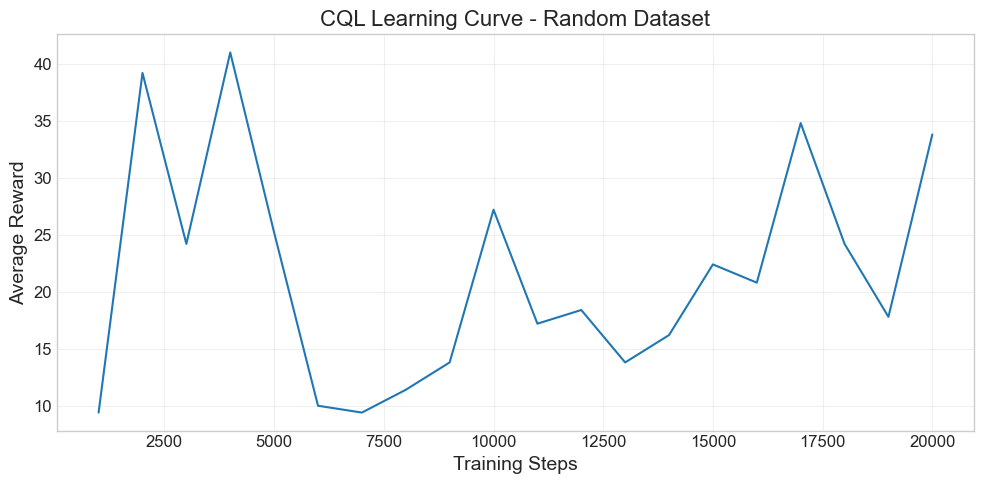


CONSERVATIVE Q-LEARNING RESULTS SUMMARY
+-----------+--------------------+-----------------+
| Dataset   | Avg Reward ± Std   | Training Time   |
+===========+====================+=================+
| Expert    | 378.45 ± 86.33     | 84.56s          |
+-----------+--------------------+-----------------+
| Mixed     | 109.05 ± 99.08     | 78.11s          |
+-----------+--------------------+-----------------+
| Random    | 27.15 ± 16.80      | 75.81s          |
+-----------+--------------------+-----------------+


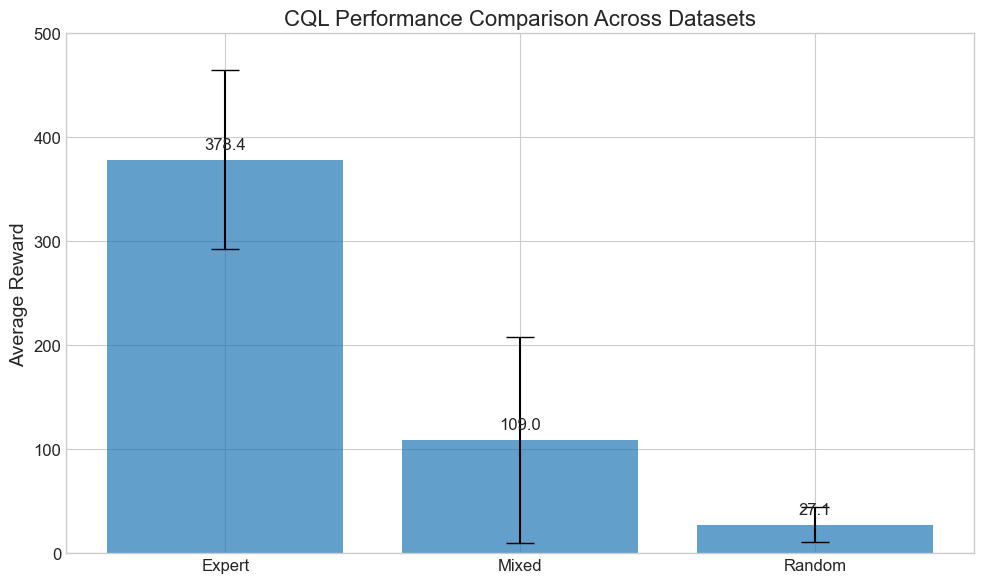

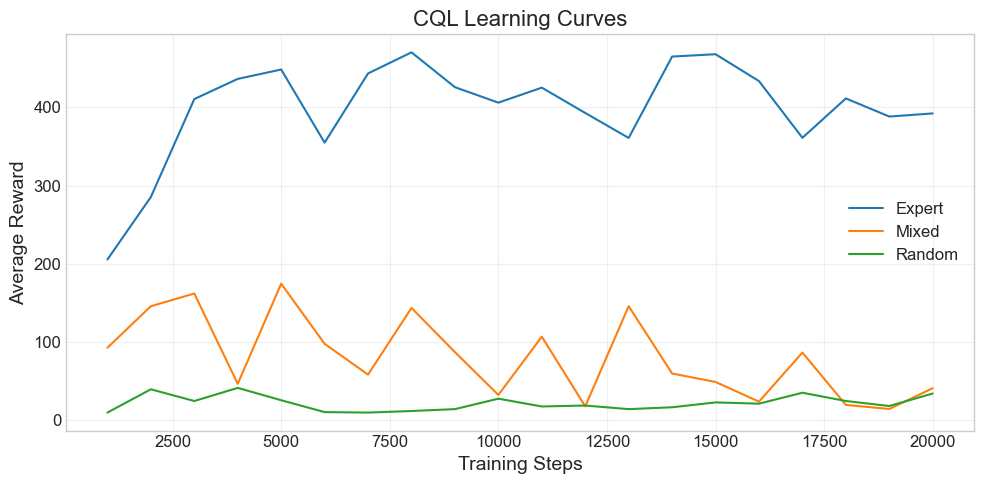

In [ ]:

cql_results = run_cql_experiments()


FINAL PERFORMANCE COMPARISON (TABLE 2)
+-------------+----------------+-----------------+----------------+
|             | Expert         | Mixed           | Random         |
+=============+================+=================+================+
| BC          | 402.65 ± 73.72 | 137.35 ± 110.35 | 21.05 ± 4.53   |
+-------------+----------------+-----------------+----------------+
| Offline DQN | 9.45 ± 0.74    | 435.95 ± 78.14  | 226.65 ± 51.12 |
+-------------+----------------+-----------------+----------------+
| CQL         | 378.45 ± 86.33 | 109.05 ± 99.08  | 27.15 ± 16.80  |
+-------------+----------------+-----------------+----------------+

LaTeX table saved to comparison_table.tex


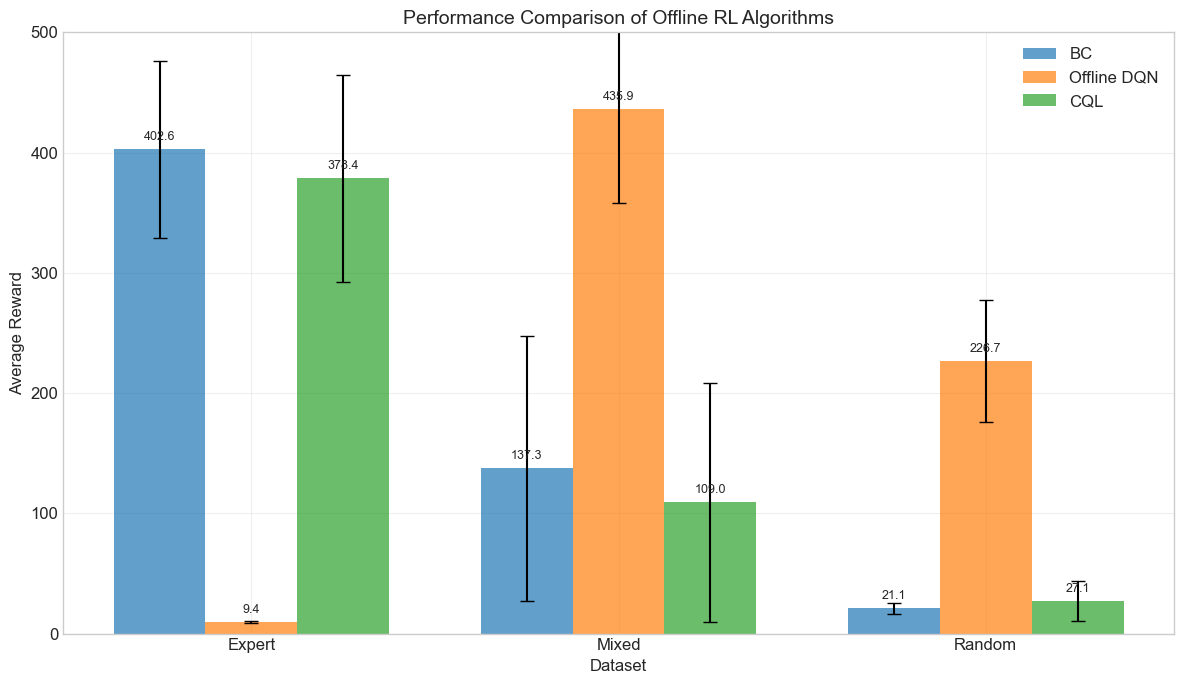

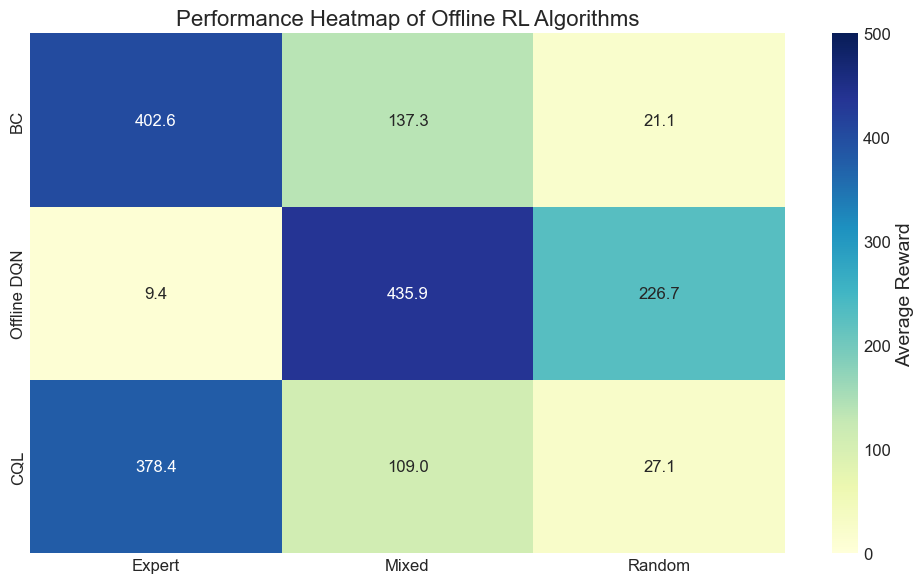


TRAINING TIME COMPARISON
+-------------+---------------------+
| Algorithm   | Avg Training Time   |
+=============+=====================+
| BC          | 1.97s               |
+-------------+---------------------+
| Offline DQN | 6.09s               |
+-------------+---------------------+
| CQL         | 79.49s              |
+-------------+---------------------+


In [34]:
comparison_df = run_comparison_analysis(bc_results, dqn_results, cql_results)

In [36]:
# bc_results, dqn_results, cql_results, comparison_df